In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xarray as xr
import glob
from geopy.distance import geodesic
import numpy as np

from scripts.plots import *

from pathlib import Path
#from cmcrameri import cm
from calendar import monthrange


warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

NameError: name 'cfg' is not defined

## 1. Load in available datasets

In [3]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all.csv')
data_FR = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/csv/FR_wgms_dataset_all_oggm_with_blanc.csv')
data_FR = data_FR[data_FR['PERIOD']!='summer']
#data_IT_AT = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/IT_AT/csv/IT_AT_wgms_dataset_all_oggm_with_millanv.csv')
#data_IT = data_IT_AT[data_IT_AT['POINT_ID'].str.endswith('_IT')]
#data_AT = data_IT_AT[data_IT_AT['POINT_ID'].str.endswith('_AT')]
data_NOR = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/Nor_dataset_all_oggm_with_millanv.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm_with_hugonnetdhdt.csv')


display(data_NOR.head(2))

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702              471   20120925  20131107          -4.92   
1   70.12521   21.76711              540   20120925  20131107          -3.83   

   PERIOD           RGIId  YEAR            GLACIER DATA_MODIFICATION  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen               NaN   
1  annual  RGI60-08.01258  2013  Langfjordjoekulen               NaN   

                                            POINT_ID     aspect      slope  \
0  Langfjordjoekulen_2013_annual_70.12589_21.7770...  36.073272  15.972541   
1  Langfjordjoekulen_2013_annual_70.12521_21.7671...  65.884818  12.091276   

         topo  hugonnet_dhdt  consensus_ice_thickness  millan_v  
0  425.458893      -3.314563                96.980293       NaN  
1  523.195557      -2.681456               100.969521       NaN

###### Some Plots to try

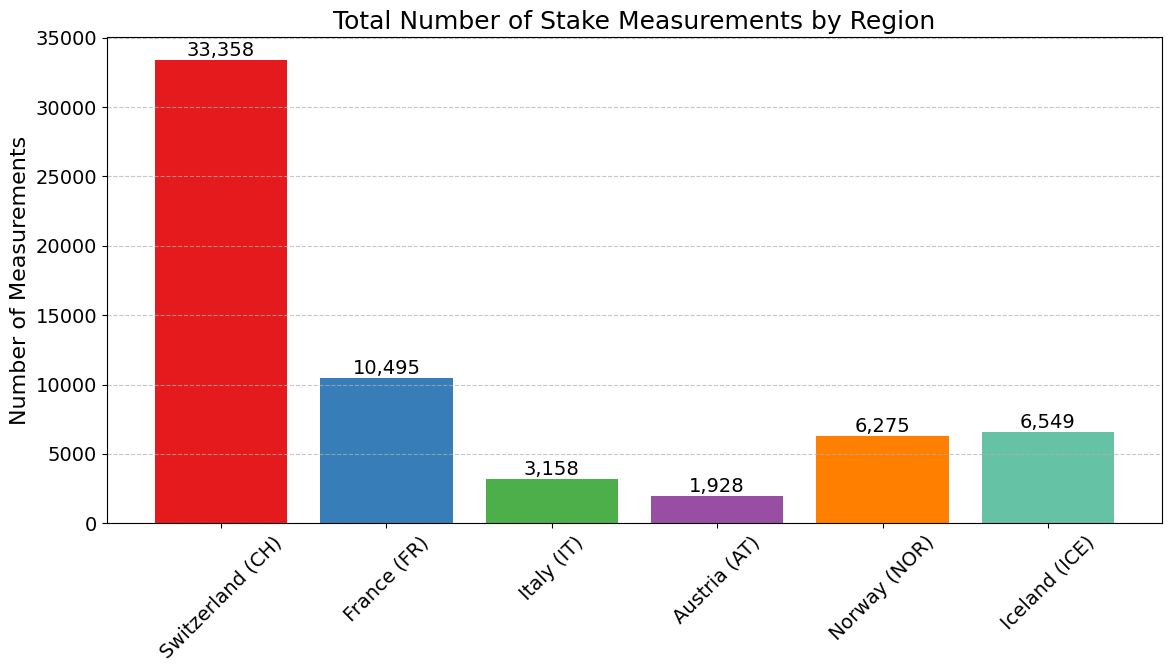

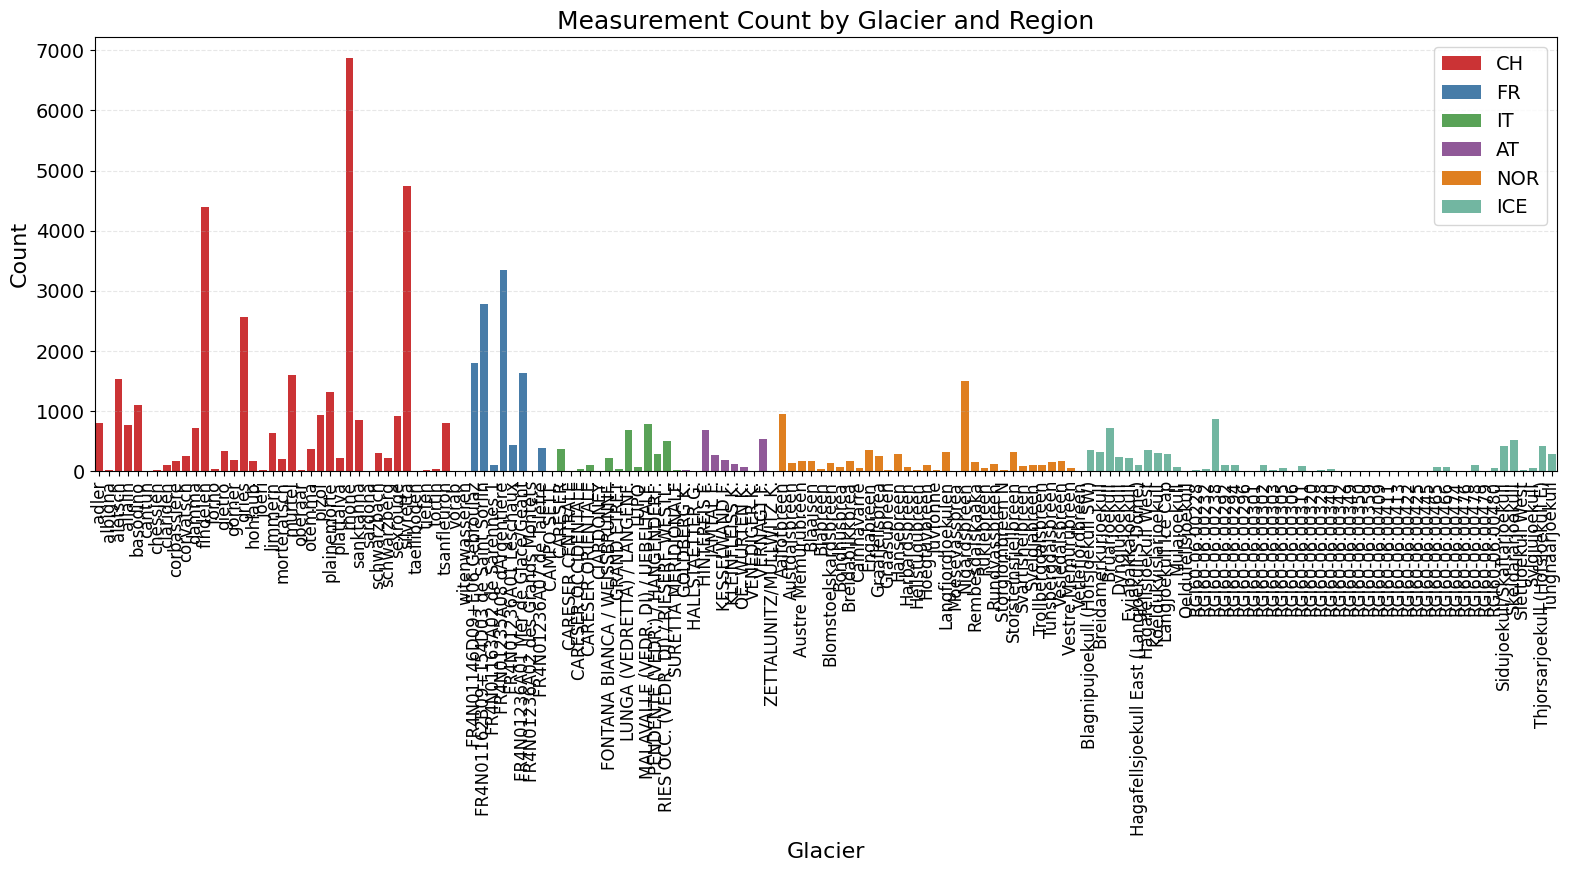

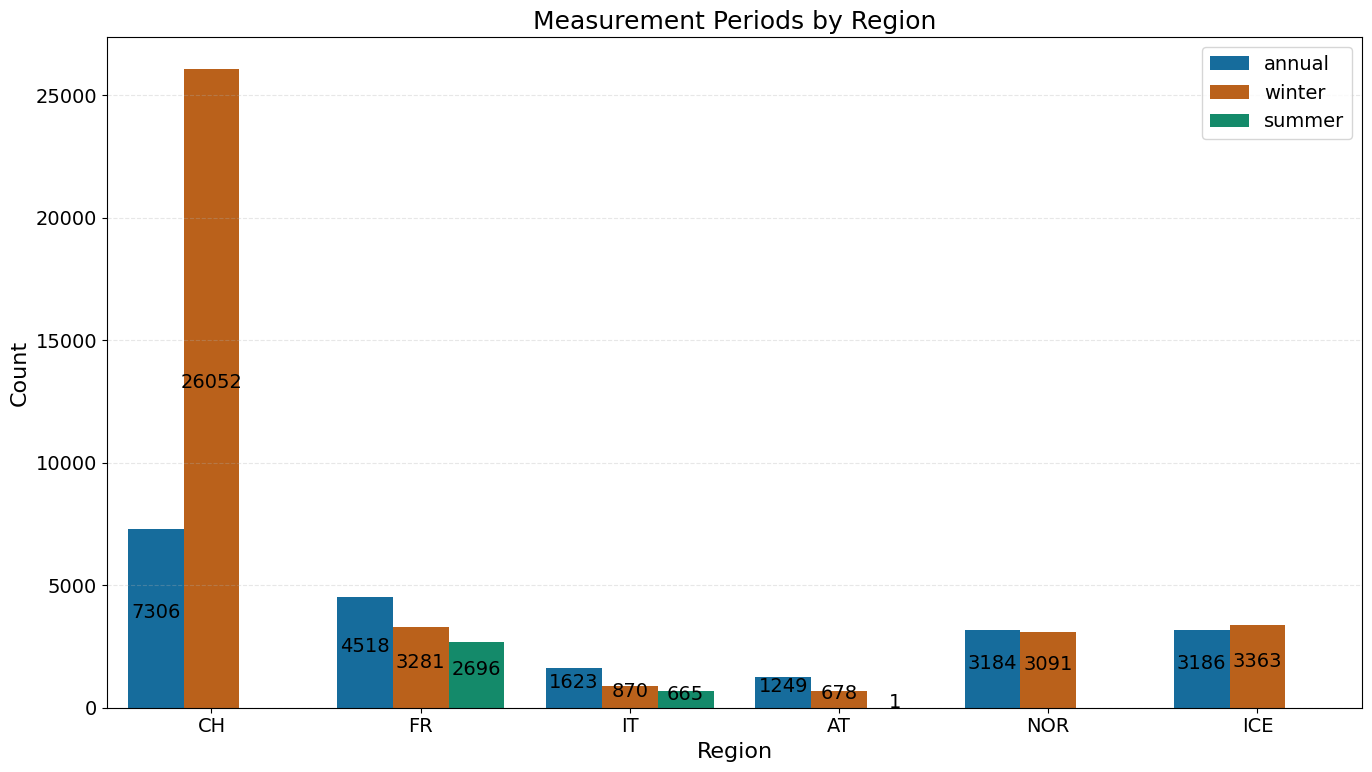

In [ ]:
# Set global matplotlib parameters for larger fonts
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

fontsize = 16  # Increased from 12

### Basic dataset size comparison
dataset_sizes = {
    'Switzerland (CH)': len(data_CH),
    'France (FR)': len(data_FR),
    'Italy (IT)': len(data_IT),
    'Austria (AT)': len(data_AT),
    'Norway (NOR)': len(data_NOR),
    'Iceland (ICE)': len(data_ICE)
}

fig, ax = plt.subplots(figsize=(12, 7))  # Slightly larger figure
bars = ax.bar(dataset_sizes.keys(), dataset_sizes.values(), color=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#66c2a5'])

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height):,}', ha='center', va='bottom', fontsize=14)

ax.set_title('Total Number of Stake Measurements by Region', fontsize=18)
ax.set_ylabel('Number of Measurements', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

### Number of unique glaciers per region and their measurement counts
glacier_counts = pd.DataFrame()

for name, df in {'CH': data_CH, 'FR': data_FR, 'IT': data_IT, 
                'AT': data_AT, 'NOR': data_NOR, 'ICE': data_ICE}.items():
    # Count measurements per glacier
    gl_counts = df.groupby('GLACIER').size().reset_index()
    gl_counts.columns = ['Glacier', 'Count']
    gl_counts['Region'] = name
    glacier_counts = pd.concat([glacier_counts, gl_counts])

plt.figure(figsize=(16, 9))  # Larger figure
ax = sns.barplot(data=glacier_counts, x='Glacier', y='Count', hue='Region',
                palette=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#66c2a5'])
plt.title('Measurement Count by Glacier and Region', fontsize=18)
plt.xlabel('Glacier', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=90, fontsize=12)  # Smaller font for many x-labels
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

### Period distribution (annual, winter, summer)
period_dist = pd.DataFrame()

for name, df in {'CH': data_CH, 'FR': data_FR, 'IT': data_IT, 
                'AT': data_AT, 'NOR': data_NOR, 'ICE': data_ICE}.items():
    pd_counts = df.groupby('PERIOD').size().reset_index()
    pd_counts.columns = ['Period', 'Count']
    pd_counts['Region'] = name
    period_dist = pd.concat([period_dist, pd_counts])

plt.figure(figsize=(14, 8))
ax = sns.barplot(data=period_dist, x='Region', y='Count', hue='Period',
                palette=['#0072B2', '#D55E00', '#009E73'])
plt.title('Measurement Periods by Region', fontsize=18)
plt.xlabel('Region', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:
        ax.annotate(f'{int(height)}', (x + width/2, y + height*0.5), ha='center', fontsize=14)

plt.tight_layout()

###### Summary data

In [ ]:
summary_data = []

for name, df in {'CH': data_CH, 'FR': data_FR, 'IT': data_IT, 
                'AT': data_AT, 'NOR': data_NOR, 'ICE': data_ICE}.items():
    
    # Calculate statistics for this region
    summary = {
        'Region': name,
        'Total Measurements': len(df),
        'Unique Glaciers': df['GLACIER'].nunique(),
        'Year Range': f"{df['YEAR'].min()}-{df['YEAR'].max()}",
        'Elevation Range (m)': f"{int(df['POINT_ELEVATION'].min())}-{int(df['POINT_ELEVATION'].max())}",
        'Mean Annual Balance (m w.e.)': df[df['PERIOD'] == 'annual']['POINT_BALANCE'].mean(),
        'Mean Winter Balance (m w.e.)': df[df['PERIOD'] == 'winter']['POINT_BALANCE'].mean(),
        'Mean Summer Balance (m w.e.)': df[df['PERIOD'] == 'summer']['POINT_BALANCE'].mean() if 'summer' in df['PERIOD'].values else np.nan,
    }
    
    summary_data.append(summary)

# Create DataFrame from summary data
summary_df = pd.DataFrame(summary_data)

# Display nicely formatted table
display(summary_df.style.format({
    'Mean Annual Balance (m w.e.)': '{:.2f}',
    'Mean Winter Balance (m w.e.)': '{:.2f}',
    'Mean Summer Balance (m w.e.)': '{:.2f}'
}))

In [ ]:
import folium
from folium import plugins

def add_dataset_to_map(data, dataset_name, color, m):
    
    unique_glaciers = data['GLACIER'].unique()
    print(f"Found {len(unique_glaciers)} unique glaciers in {dataset_name}")
    
    for glacier_name in unique_glaciers:
        glacier_data = data[data['GLACIER'] == glacier_name]
        
        max_points = 30  # Maximum number of points to show per glacier
        if len(glacier_data) > max_points:
            glacier_data = glacier_data.sample(max_points, random_state=20)
        
        # Add points to map
        for idx, row in glacier_data.iterrows():
            if 'POINT_ELEVATION' in row:
                altitude = row['POINT_ELEVATION']
            else:
                altitude = 'N/A'
                
            if 'POINT_ID' in row:
                stake_id = row['POINT_ID'].split('_')[-1][:5]
            else:
                stake_id = str(idx)
                
            # Get coordinates
            lat = row['POINT_LAT'] #if 'POINT_LAT' in row else row['lat']
            lon = row['POINT_LON'] #if 'POINT_LON' in row else row['lon']
                
            popup_text = f"""
            Dataset: {dataset_name}<br>
            Glacier: {glacier_name}<br>
            ID: {stake_id}<br>
            Altitude: {altitude}m<br>
            """
            
            # Add marker
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                popup=popup_text,
                tooltip=f"{dataset_name} - {glacier_name}",
                color=color,
                fill=True,
                fill_color=color
            ).add_to(m)

colors = {
    'CH': '#e41a1c',   # red
    'FR': '#377eb8',   # blue
    'IT': '#66c2a5',   # teal
    'AT': '#984ea3',   # purple
    'NOR': '#ff7f00',  # orange
    'ICE': '#4daf4a'   # green
}

datasets = {
    'CH': data_CH,
    'FR': data_FR, 
    'IT': data_IT,
    'AT': data_AT,
    'NOR': data_NOR,
    'ICE': data_ICE
}

all_lats = []
all_lons = []

for name, dataset in datasets.items():
    lat_col = 'POINT_LAT' if 'POINT_LAT' in dataset.columns else 'lat'
    lon_col = 'POINT_LON' if 'POINT_LON' in dataset.columns else 'lon'
    
    if not dataset.empty:
        all_lats.extend(dataset[lat_col].dropna().tolist())
        all_lons.extend(dataset[lon_col].dropna().tolist())


center_lat = 46.0
center_lon = 8.0

# Create map
m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Add datasets to map
for name, dataset in datasets.items():
    add_dataset_to_map(dataset, name, colors[name], m)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border-radius: 5px;">
    <p><strong>Datasets</strong></p>
'''

for name, color in colors.items():
    legend_html += f'<p><span style="color: {color};">●</span> {name}</p>'

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Add fullscreen option and layer control
plugins.Fullscreen().add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

# Save the map as an HTML file
m.save('/home/mburlet/MBM/MassBalanceMachine/regions/Overview/glacier_overview_map_with_ICE.html')

Found 39 unique glaciers in CH
Found 8 unique glaciers in FR
Found 14 unique glaciers in IT
Found 10 unique glaciers in AT
Found 32 unique glaciers in NOR
Found 49 unique glaciers in ICE


In [ ]:
import folium
from folium import plugins
import matplotlib.colors as mcolors

data_to_plot = data_ICE

year_to_plot = 2015

data_year = data_to_plot[data_to_plot['TO_DATE'].astype(str).str[:4] == str(year_to_plot)]

unique_glaciers = data_year['GLACIER'].unique()

# Dynamic Color assignment
color_options = list(mcolors.TABLEAU_COLORS.values())
# Add more colors if needed
color_options.extend(['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', 
                     '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62'])

glacier_colors = {}
for i, glacier in enumerate(unique_glaciers):
    glacier_colors[glacier] = color_options[i % len(color_options)]  # Use modulo to handle more glaciers than colors

# Map center
center_lat = 46.0
center_lon = 8.0

# Create the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Function to add markers for a glacier's stakes
def add_glacier_markers(glacier_data, glacier_name):
    # Determine coordinate column names
    lat_col = 'POINT_LAT' #if 'POINT_LAT' in glacier_data.columns else 'lat'
    lon_col = 'POINT_LON' #if 'POINT_LON' in glacier_data.columns else 'lon'
    
    # Get color for the glacier
    color = glacier_colors[glacier_name]
    
    # Add point for each stake
    for idx, row in glacier_data.iterrows():
        # Determine elevation and stake ID
        if 'POINT_ELEVATION' in row:
            altitude = row['POINT_ELEVATION']
        elif 'altitude' in row:
            altitude = row['altitude']
        else:
            altitude = 'N/A'
            
        if 'stake_number' in row:
            stake_id = row['stake_number']
        elif 'POINT_ID' in row:
            stake_id = row['POINT_ID'].split('_')[-1]  # Extract stake number from POINT_ID
        else:
            stake_id = f"Stake {idx}"
            
        # Create popup content
        popup_text = f"""
        Glacier: {glacier_name}<br>
        Year: {year_to_plot}<br>
        Stake: {stake_id}<br>
        Altitude: {altitude}m<br>
        """
        
        if 'POINT_BALANCE' in row:
            popup_text += f"Balance: {row['POINT_BALANCE']} m w.e.<br>"
        
        # Add marker
        folium.CircleMarker(
            location=[row[lat_col], row[lon_col]],
            radius=5,
            popup=popup_text,
            tooltip=f"{glacier_name} - {stake_id}",
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            weight=1
        ).add_to(m)

# Add markers for each glacier's stakes in the selected year
for glacier in unique_glaciers:
    glacier_data = data_year[data_year['GLACIER'] == glacier]
    add_glacier_markers(glacier_data, glacier)

# Add title to the map
title_html = f'''
<h3 align="center" style="font-size:16px"><b>Glacier Stakes in {year_to_plot}</b></h3>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border-radius: 5px;">
    <p><strong>Glaciers</strong></p>
'''

for glacier, color in glacier_colors.items():
    # Count stakes for this glacier in the selected year
    count = len(data_year[data_year['GLACIER'] == glacier])
    legend_html += f'<p><span style="color: {color};">●</span> {glacier} ({count} stakes)</p>'

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Add fullscreen option and layer control
plugins.Fullscreen().add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

### 2. Individual dataset stats

##### France

In [ ]:
display(data_FR.head(2))

fig, ax = plt.subplots(figsize=(20, 3.2))
data_FR.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#33a02c', '#e31a1c'],
    ax=ax)
plt.title('France', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)



plotHeatmap(list(data_FR['GLACIER'].unique()), data_FR, period='annual', figsize=(20, 5))

plotHeatmap(list(data_FR['GLACIER'].unique()), data_FR, period='winter', figsize=(20, 5))

plotHeatmap(list(data_FR['GLACIER'].unique()), data_FR, period='summer', figsize=(20, 5))

gl_per_el = data_FR.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
plot_glacier_elevations(gl_per_el)



In [ ]:
fig, ax = plt.subplots(figsize=(20, 3.2))
data_FR.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#33a02c', '#e31a1c'],
    ax=ax)
plt.title('France', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

fig, ax = plt.subplots(figsize=(20, 3.2))
data_IT.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#33a02c', '#e31a1c'],
    ax=ax)
plt.title('Italy', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

fig, ax = plt.subplots(figsize=(20, 3.2))
data_AT.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#33a02c', '#e31a1c'],
    ax=ax)
plt.title('Austria', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

fig, ax = plt.subplots(figsize=(20, 3.2))
data_NOR.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#e31a1c'],
    ax=ax)
plt.title('Norway', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

fig, ax = plt.subplots(figsize=(20, 3.2))
data_ICE.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#e31a1c'],
    ax=ax)
plt.title('Iceland', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

#### Italy

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3.2))
data_IT.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#1f78b4', '#33a02c', '#e31a1c'],
    ax=ax)
plt.title('Italy', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

plotHeatmap(list(data_IT['GLACIER'].unique()), data_IT, period='annual', figsize=(20, 5))

plotHeatmap(list(data_IT['GLACIER'].unique()), data_IT, period='winter', figsize=(20, 5))

plotHeatmap(list(data_IT['GLACIER'].unique()), data_IT, period='summer', figsize=(20, 5))

gl_per_el = data_IT.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
plot_glacier_elevations(gl_per_el, figsize =(10,5))

In [ ]:
(data_IT[data_IT['GLACIER'] == 'GRAND ETRET'])
#2700	-1.279	2008	GRAND ETRET_2008_32398_IT	-18.242163	annual	GRAND ETRET
#2701	-2.427	2008	GRAND ETRET_2008_32396_IT	-23.507818	annual	GRAND ETRET

#### Austria

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3.2))
data_AT.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#0072B2', '#D55E00', '#009E73'],
    ax=ax)
plt.title('Austria', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

plotHeatmap(list(data_AT['GLACIER'].unique()), data_AT, period='annual', figsize=(20, 5))

plotHeatmap(list(data_AT['GLACIER'].unique()), data_AT, period='winter', figsize=(20, 5))

gl_per_el = data_AT.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
plot_glacier_elevations(gl_per_el, figsize =(10,5))

display(data_AT[data_AT['GLACIER'] == 'VERNAGT F.'])

#### Norway

###### Summer stakes have been preemptively removed, as this dataset is only used for transfer learning CH to NOR

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3.2))
data_NOR.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#0072B2', '#D55E00', '#009E73'],
    ax=ax)
plt.title('Norway', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

plotHeatmap(list(data_NOR['GLACIER'].unique()), data_NOR, period='annual', figsize=(20, 8))

plotHeatmap(list(data_NOR['GLACIER'].unique()), data_NOR, period='winter', figsize=(20, 8))

gl_per_el = data_NOR.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
plot_glacier_elevations(gl_per_el, figsize =(10,5))

#### Iceland

###### Summer stakes have been preemptively removed, as this dataset is only used for transfer learning CH to NOR

In [ ]:
fig, ax = plt.subplots(figsize=(20, 3.2))
data_ICE.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    color=['#0072B2', '#D55E00', '#009E73'],
    ax=ax)
plt.title('Iceland', fontsize=24)
ax.set_xlabel('', fontsize=18)
ax.set_ylabel('Number of measurements', fontsize=18)
ax.tick_params(axis='both', labelsize=16)
ax.legend(fontsize=16)

plotHeatmap(list(data_ICE['GLACIER'].unique()), data_ICE, period='annual', figsize=(20, 8))

plotHeatmap(list(data_ICE['GLACIER'].unique()), data_ICE, period='winter', figsize=(20, 8))

gl_per_el = data_ICE.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
plot_glacier_elevations(gl_per_el, figsize =(10,5))

### 3. Results XGBoost split

##### FR split tested on Gebroulaz

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_Gebroulaz.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('FR split tested on Gebroulaz')
plt.tight_layout()
plt.show()

img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_Leschaux.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('FR split tested on Gebroulaz')
plt.tight_layout()
plt.show()


### 4. Result XGBoost transfer

##### CH train FR Test

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_CH_FR_no_summer.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('CH train FR Test')
plt.tight_layout()
plt.show()

img2 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/individual_glaciers_CH_FR_no_summer.png')
plt.figure(figsize=(10, 8))
plt.imshow(img2)
plt.axis('off')
plt.title('Individual Glaciers: CH train FR Test')
plt.tight_layout()
plt.show()



##### IT train AT test

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_train_IT_test_AT.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('IT train AT test')
plt.tight_layout()
plt.show()

img2 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/individual_glaciers_train_IT_test_AT.png')
plt.figure(figsize=(10, 8))
plt.imshow(img2)
plt.axis('off')
plt.title('Individual Glaciers: IT train AT test')
plt.tight_layout()
plt.show()

CH train IT & AT test

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_train_CH_test_IT_AT.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('CH train IT & AT test')
plt.tight_layout()
plt.show()

img2 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/individual_glaciers_train_CH_test_IT_AT.png')
plt.figure(figsize=(10, 8))
plt.imshow(img2)
plt.axis('off')
plt.title('Individual Glaciers: CH train IT & AT test')
plt.tight_layout()
plt.show()

##### CH train NOR test

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_CH_NOR.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('CH train NOR test')
plt.tight_layout()
plt.show()

img2 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/individual_galciers_CH_NOR.png')
plt.figure(figsize=(20, 15))
plt.imshow(img2)
plt.axis('off')
plt.title('Individual Glaciers: CH train NOR test')
plt.tight_layout()
plt.show()

Possible next steps: 
- clean up regions code, rerun all results
- iceland data and transfer learning test
- NN transfer learning comparison and potential improvement
- WGMS dataset has many more potential regions (worth to look at?)


### Iceland

##### Iceland west train east test

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_ICE.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Iceland west train Iceland east test')
plt.tight_layout()
plt.show()

img2 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/individual_galciers_ICE.png')
plt.figure(figsize=(20, 15))
plt.imshow(img2)
plt.axis('off')
plt.title('Individual Glaciers: Iceland west train Iceland east test')
plt.tight_layout()
plt.show()

##### CH train ICE test

In [ ]:
img = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_train_CH_test_ICE.png')

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('CH train ICE test')
plt.tight_layout()
plt.show()

img2 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/Result_summary_train_CH_test_ICE.png')
plt.figure(figsize=(10, 8))
plt.imshow(img2)
plt.axis('off')
plt.title('CH train ICE test')
plt.tight_layout()
plt.show()

img3 = mpimg.imread('/home/mburlet/scratch/data/DATA_MB/Outputs/individual_glaciers_train_CH_test_ICE.png')
plt.figure(figsize=(20, 25))
plt.imshow(img3)
plt.axis('off')
plt.title('Individual Glaciers: CH train ICE test')
plt.tight_layout()
plt.show()

### Climate variables comparison

In [5]:
data_CH_monthly = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_monthly_plotting.csv')
data_FR_monthly = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/csv/FR_wgms_dataset_monthly_full_no_summer.csv')
data_IT_AT_monthly = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/IT_AT/csv/IT_AT_wgms_dataset_monthly_full.csv')
data_IT_monthly = data_IT_AT_monthly[data_IT_AT_monthly['POINT_ID'].str.endswith('_IT')]
data_AT_monthly = data_IT_AT_monthly[data_IT_AT_monthly['POINT_ID'].str.endswith('_AT')]
data_NOR_monthly = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/NOR_dataset_monthly_full_with_millanv.csv')
data_ICE_monthly = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_monthly_full_with_hugonnetdhdt.csv')

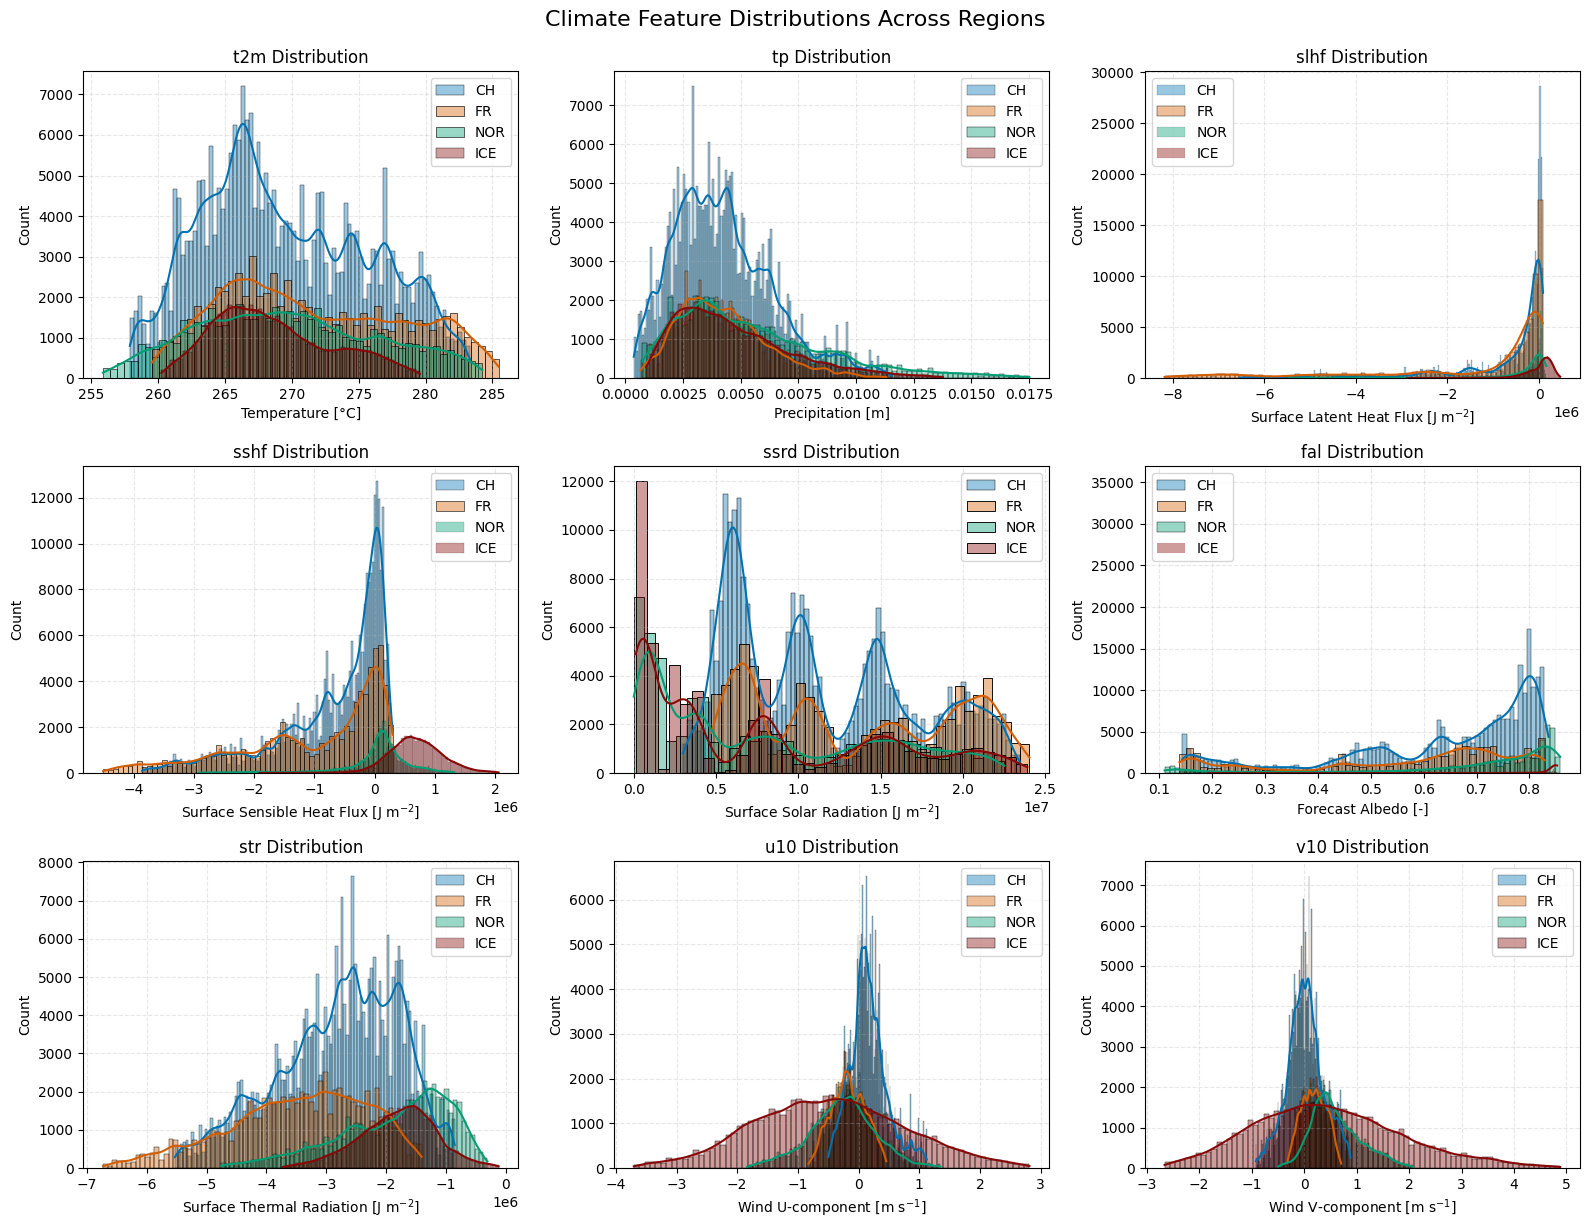

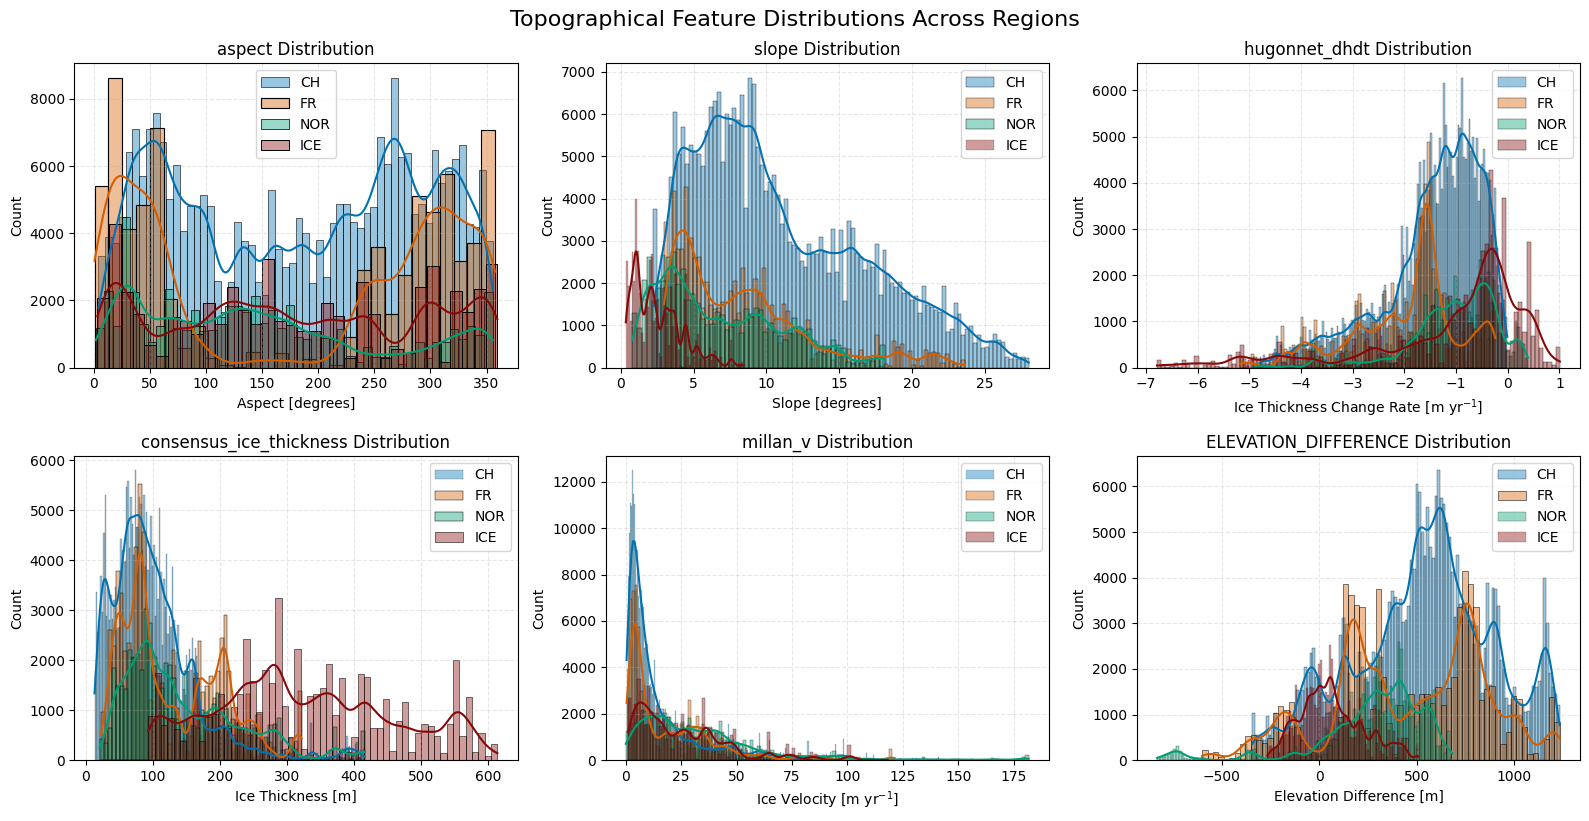

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec

# Define the climate features to plot
climate_features = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

# Define the topographical features to plot
topo_features = [
    "aspect",
    "slope",
    "hugonnet_dhdt", 
    "consensus_ice_thickness",
    "millan_v",
    "ELEVATION_DIFFERENCE"
]

# Names and units for better labels
feature_labels = {
    # Climate
    't2m': 'Temperature [°C]',
    'tp': 'Precipitation [m]',
    'slhf': 'Surface Latent Heat Flux [J m$^{-2}$]',
    'sshf': 'Surface Sensible Heat Flux [J m$^{-2}$]',
    'ssrd': 'Surface Solar Radiation [J m$^{-2}$]',
    'fal': 'Forecast Albedo [-]',
    'str': 'Surface Thermal Radiation [J m$^{-2}$]',
    'u10': 'Wind U-component [m s$^{-1}$]',
    'v10': 'Wind V-component [m s$^{-1}$]',
    # Topographical
    'aspect': 'Aspect [degrees]',
    'slope': 'Slope [degrees]',
    'hugonnet_dhdt': 'Ice Thickness Change Rate [m yr$^{-1}$]',
    'consensus_ice_thickness': 'Ice Thickness [m]',
    'millan_v': 'Ice Velocity [m yr$^{-1}$]',
    'ELEVATION_DIFFERENCE': 'Elevation Difference [m]'
}

# Define region colors (using a colorblind-friendly palette)
region_colors = {
    'CH': '#0072B2',  # blue
    'FR': '#D55E00',  # orange-red
    'IT': '#F0E442',  # yellow
    'AT': '#CC79A7',  # pink
    'NOR': '#009E73', # green
    'ICE': '#880808'  # dark red
}

# Create a function to preprocess and sample the data for more balanced comparison
def prepare_data_for_plotting(datasets):
    processed_data = {}
    
    # Process each dataset
    for region, df in datasets.items():
        # Make a copy of the dataframe to avoid modifying the original
        df_copy = df.copy()
        
        # Convert temperature from Kelvin to Celsius for better interpretability
        if 't2m' in df_copy.columns:
            df_copy['t2m'] = df_copy['t2m'] + 273.15
        
        processed_data[region] = df_copy
            
    return processed_data

def plot_feature_distributions(datasets, features, labels, colors, title):
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(16, 4*n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig)
    
    processed_data = prepare_data_for_plotting(datasets)
    
    # Create histograms for each feature
    for i, feature in enumerate(features):
        row, col = i // n_cols, i % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        # Plot histogram for each region
        for region, df in processed_data.items():
            if feature in df.columns:
                # Use robust statistics to determine plot range (exclude outliers)
                data = df[feature].dropna()
                if len(data) > 0:
                    q1, q3 = np.percentile(data, [1, 99])
                    data_range = data[(data >= q1) & (data <= q3)]
                    
                    sns.histplot(
                        data_range, 
                        kde=True, 
                        alpha=0.4, 
                        label=region,
                        color=colors[region],
                        ax=ax
                    )
        
        ax.set_xlabel(labels[feature] if feature in labels else feature)
        ax.set_title(f"{feature} Distribution")
        ax.legend()
        
        ax.grid(alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    return fig

datasets = {
    'CH': data_CH_monthly,
    'FR': data_FR_monthly,
    #'IT': data_IT_monthly,
    #'AT': data_AT_monthly,
    'NOR': data_NOR_monthly,
    'ICE': data_ICE_monthly
}

climate_fig = plot_feature_distributions(
    datasets, 
    climate_features, 
    feature_labels, 
    region_colors,
    'Climate Feature Distributions Across Regions'
)

topo_fig = plot_feature_distributions(
    datasets, 
    topo_features, 
    feature_labels, 
    region_colors,
    'Topographical Feature Distributions Across Regions'
)

Creating distribution comparisons for ALL climate features...


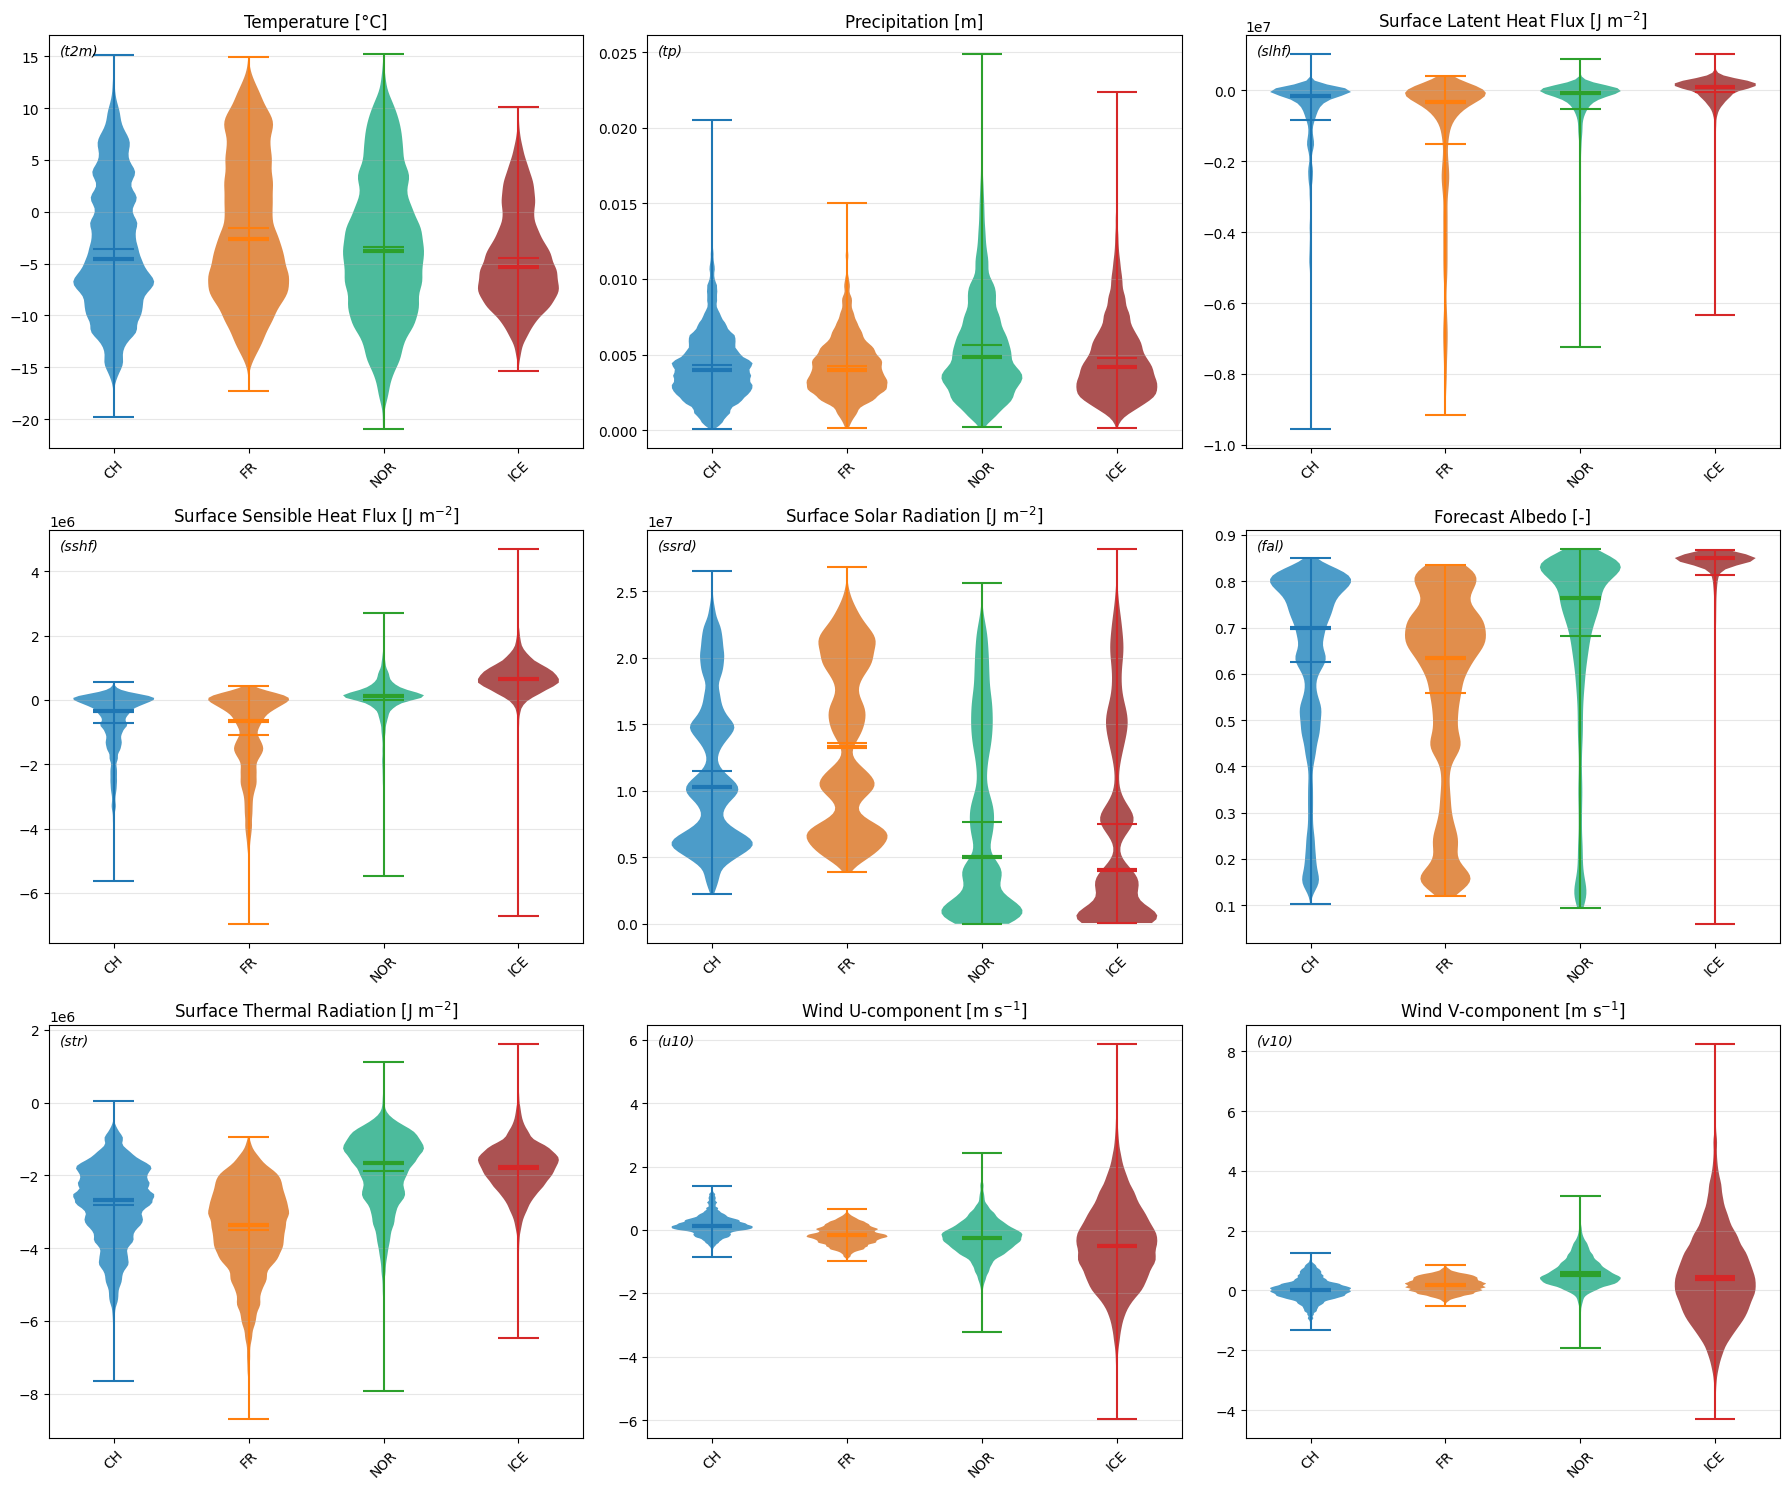


Creating distribution comparisons for ALL topographical features...


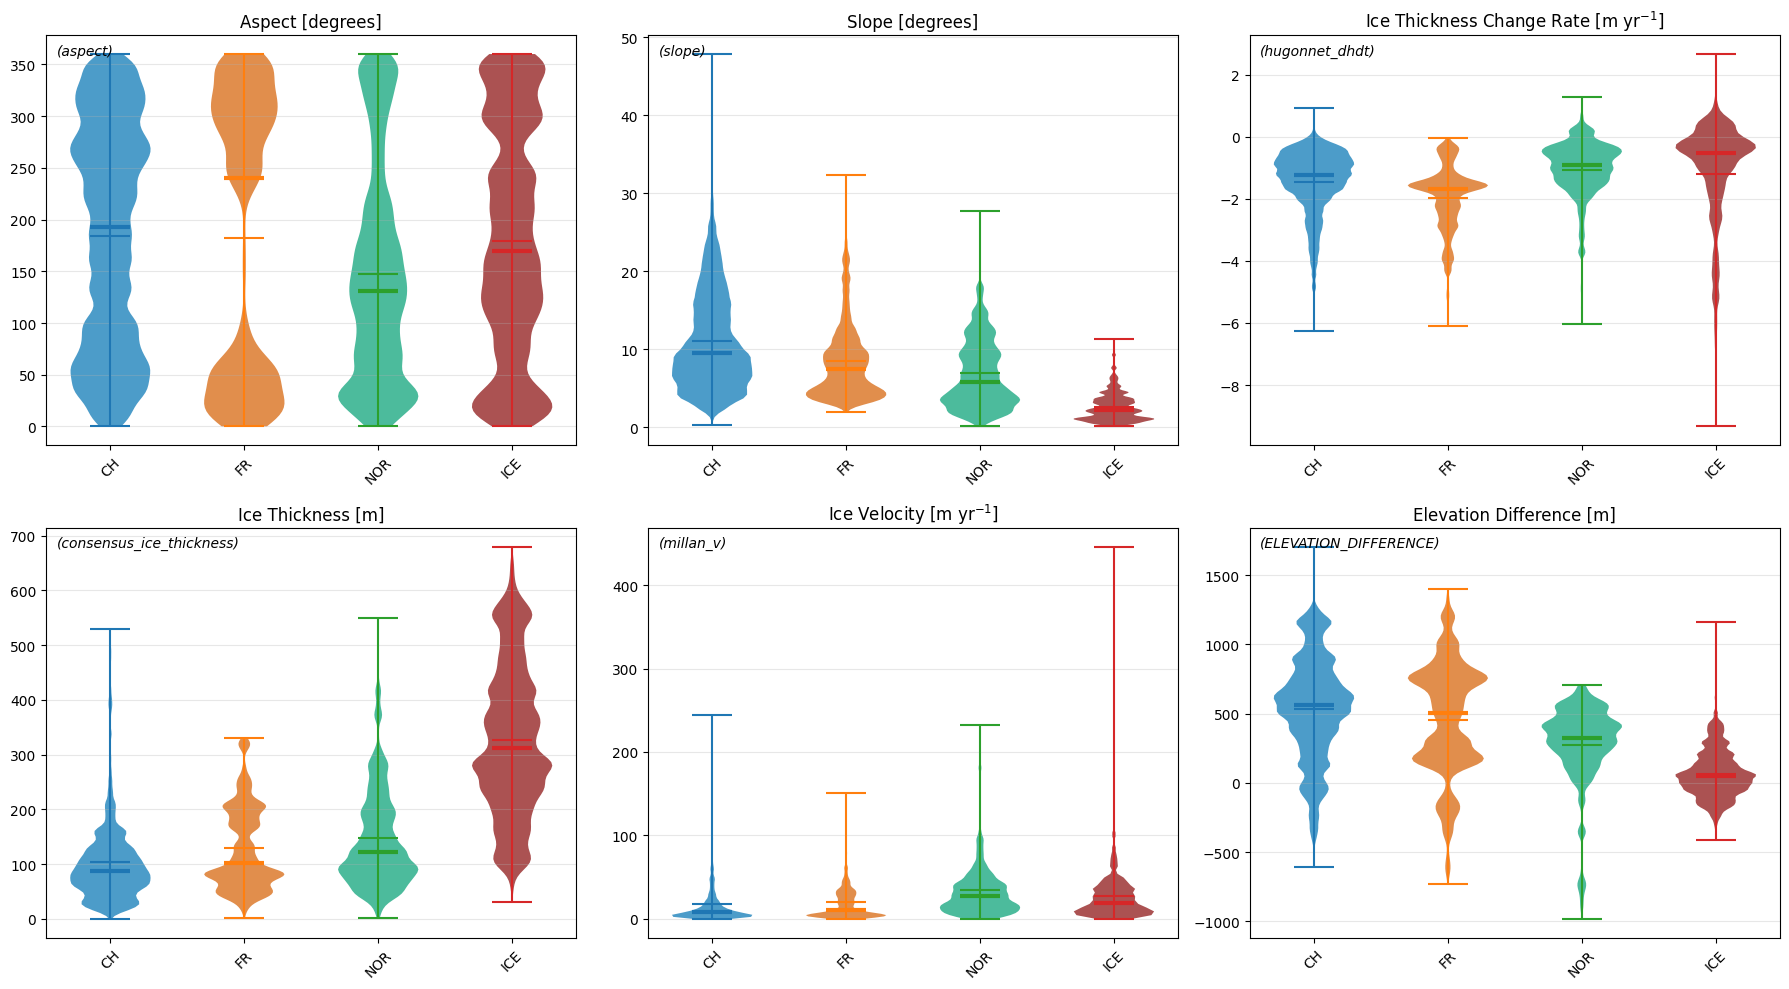

In [6]:
def plot_all_distribution_comparisons(datasets, features, feature_labels):
    """Create distribution comparison plots for ALL features"""
    
    # Filter features that exist in the datasets
    available_features = []
    for feature in features:
        if any(feature in df.columns for df in datasets.values()):
            available_features.append(feature)
    
    n_features = len(available_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    
    # Handle case where there's only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(available_features):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        region_positions = {}
        for region_idx, region in enumerate(datasets.keys()):
            region_positions[region] = region_idx
        
        for region, df in datasets.items():
            if feature in df.columns:
                data = df[feature].dropna()
                if len(data) > 0:
                    # Plot violin plot for better comparison
                    parts = ax.violinplot([data], positions=[region_positions[region]], 
                                        widths=0.6, showmeans=True, showmedians=True)
                    parts['cmedians'].set_linewidth(3)
                    parts['bodies'][0].set_facecolor(region_colors[region])
                    parts['bodies'][0].set_alpha(0.7)
        
        ax.set_xticks(range(len(datasets)))
        ax.set_xticklabels(list(datasets.keys()), rotation=45)
        ax.set_title(f'{feature_labels.get(feature, feature)}', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Add feature name as subtitle
        ax.text(0.02, 0.98, f'({feature})', transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', style='italic')
    
    # Hide empty subplots
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    return fig

# Create distribution comparisons for all climate features
print("Creating distribution comparisons for ALL climate features...")
climate_distributions_fig = plot_all_distribution_comparisons(datasets, climate_features, feature_labels)
plt.show()

# Create distribution comparisons for all topographical features  
print("\nCreating distribution comparisons for ALL topographical features...")
topo_distributions_fig = plot_all_distribution_comparisons(datasets, topo_features, feature_labels)
plt.show()

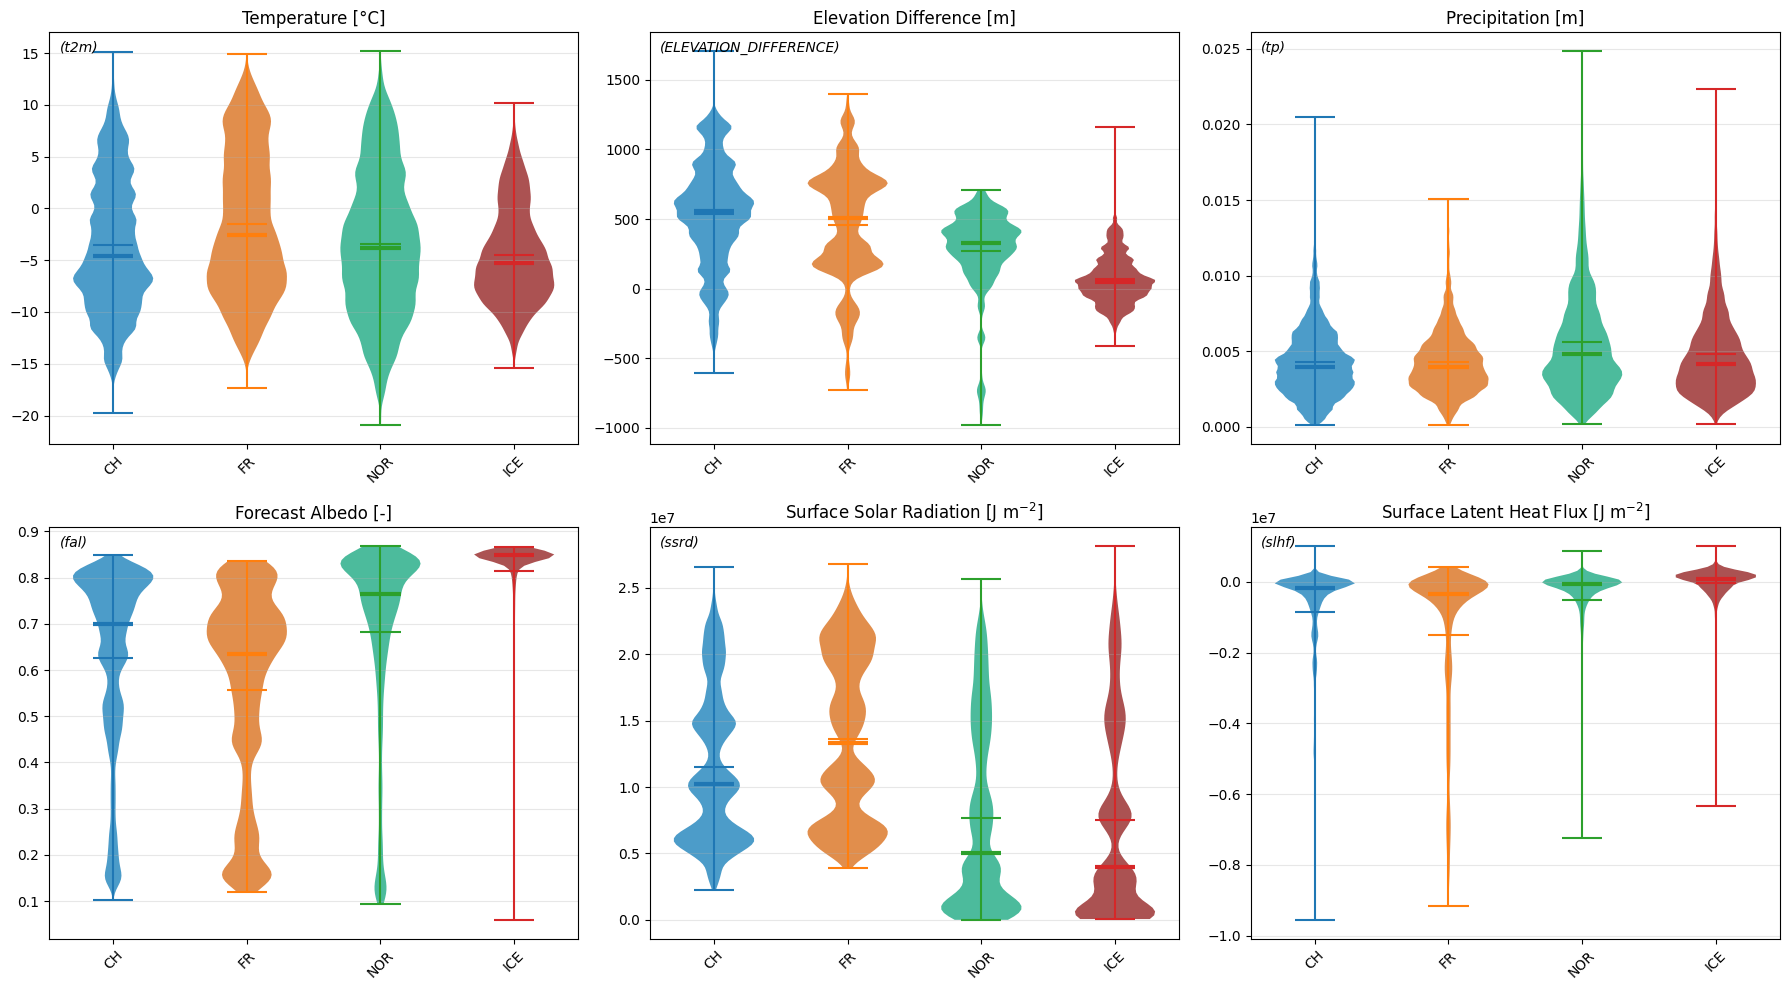

In [6]:
def plot_selected_features(datasets, selected_features, feature_labels):
    """Create distribution comparison plots for selected features (mix of topo and climate)."""
    
    # Filter features that exist in the datasets
    available_features = [feature for feature in selected_features if any(feature in df.columns for df in datasets.values())]
    
    n_features = len(available_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    
    # Handle case where there's only one row
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(available_features):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        region_positions = {region: i for i, region in enumerate(datasets.keys())}
        
        for region, df in datasets.items():
            if feature in df.columns:
                data = df[feature].dropna()
                if len(data) > 0:
                    # Plot violin plot for better comparison
                    parts = ax.violinplot([data], positions=[region_positions[region]], 
                                          widths=0.6, showmeans=True, showmedians=True)
                    parts['cmedians'].set_linewidth(3)
                    parts['bodies'][0].set_facecolor(region_colors[region])
                    parts['bodies'][0].set_alpha(0.7)
        
        ax.set_xticks(range(len(datasets)))
        ax.set_xticklabels(list(datasets.keys()), rotation=45)
        ax.set_title(f'{feature_labels.get(feature, feature)}', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Add feature name as subtitle
        ax.text(0.02, 0.98, f'({feature})', transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', style='italic')
    
    # Hide empty subplots
    for idx in range(n_features, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    return fig

selected_features = ['t2m', 'ELEVATION_DIFFERENCE','tp', 'fal', 'ssrd', 'slhf']  # Mix of climate and topo features
mixed_features_fig = plot_selected_features(datasets, selected_features, feature_labels)
plt.show()

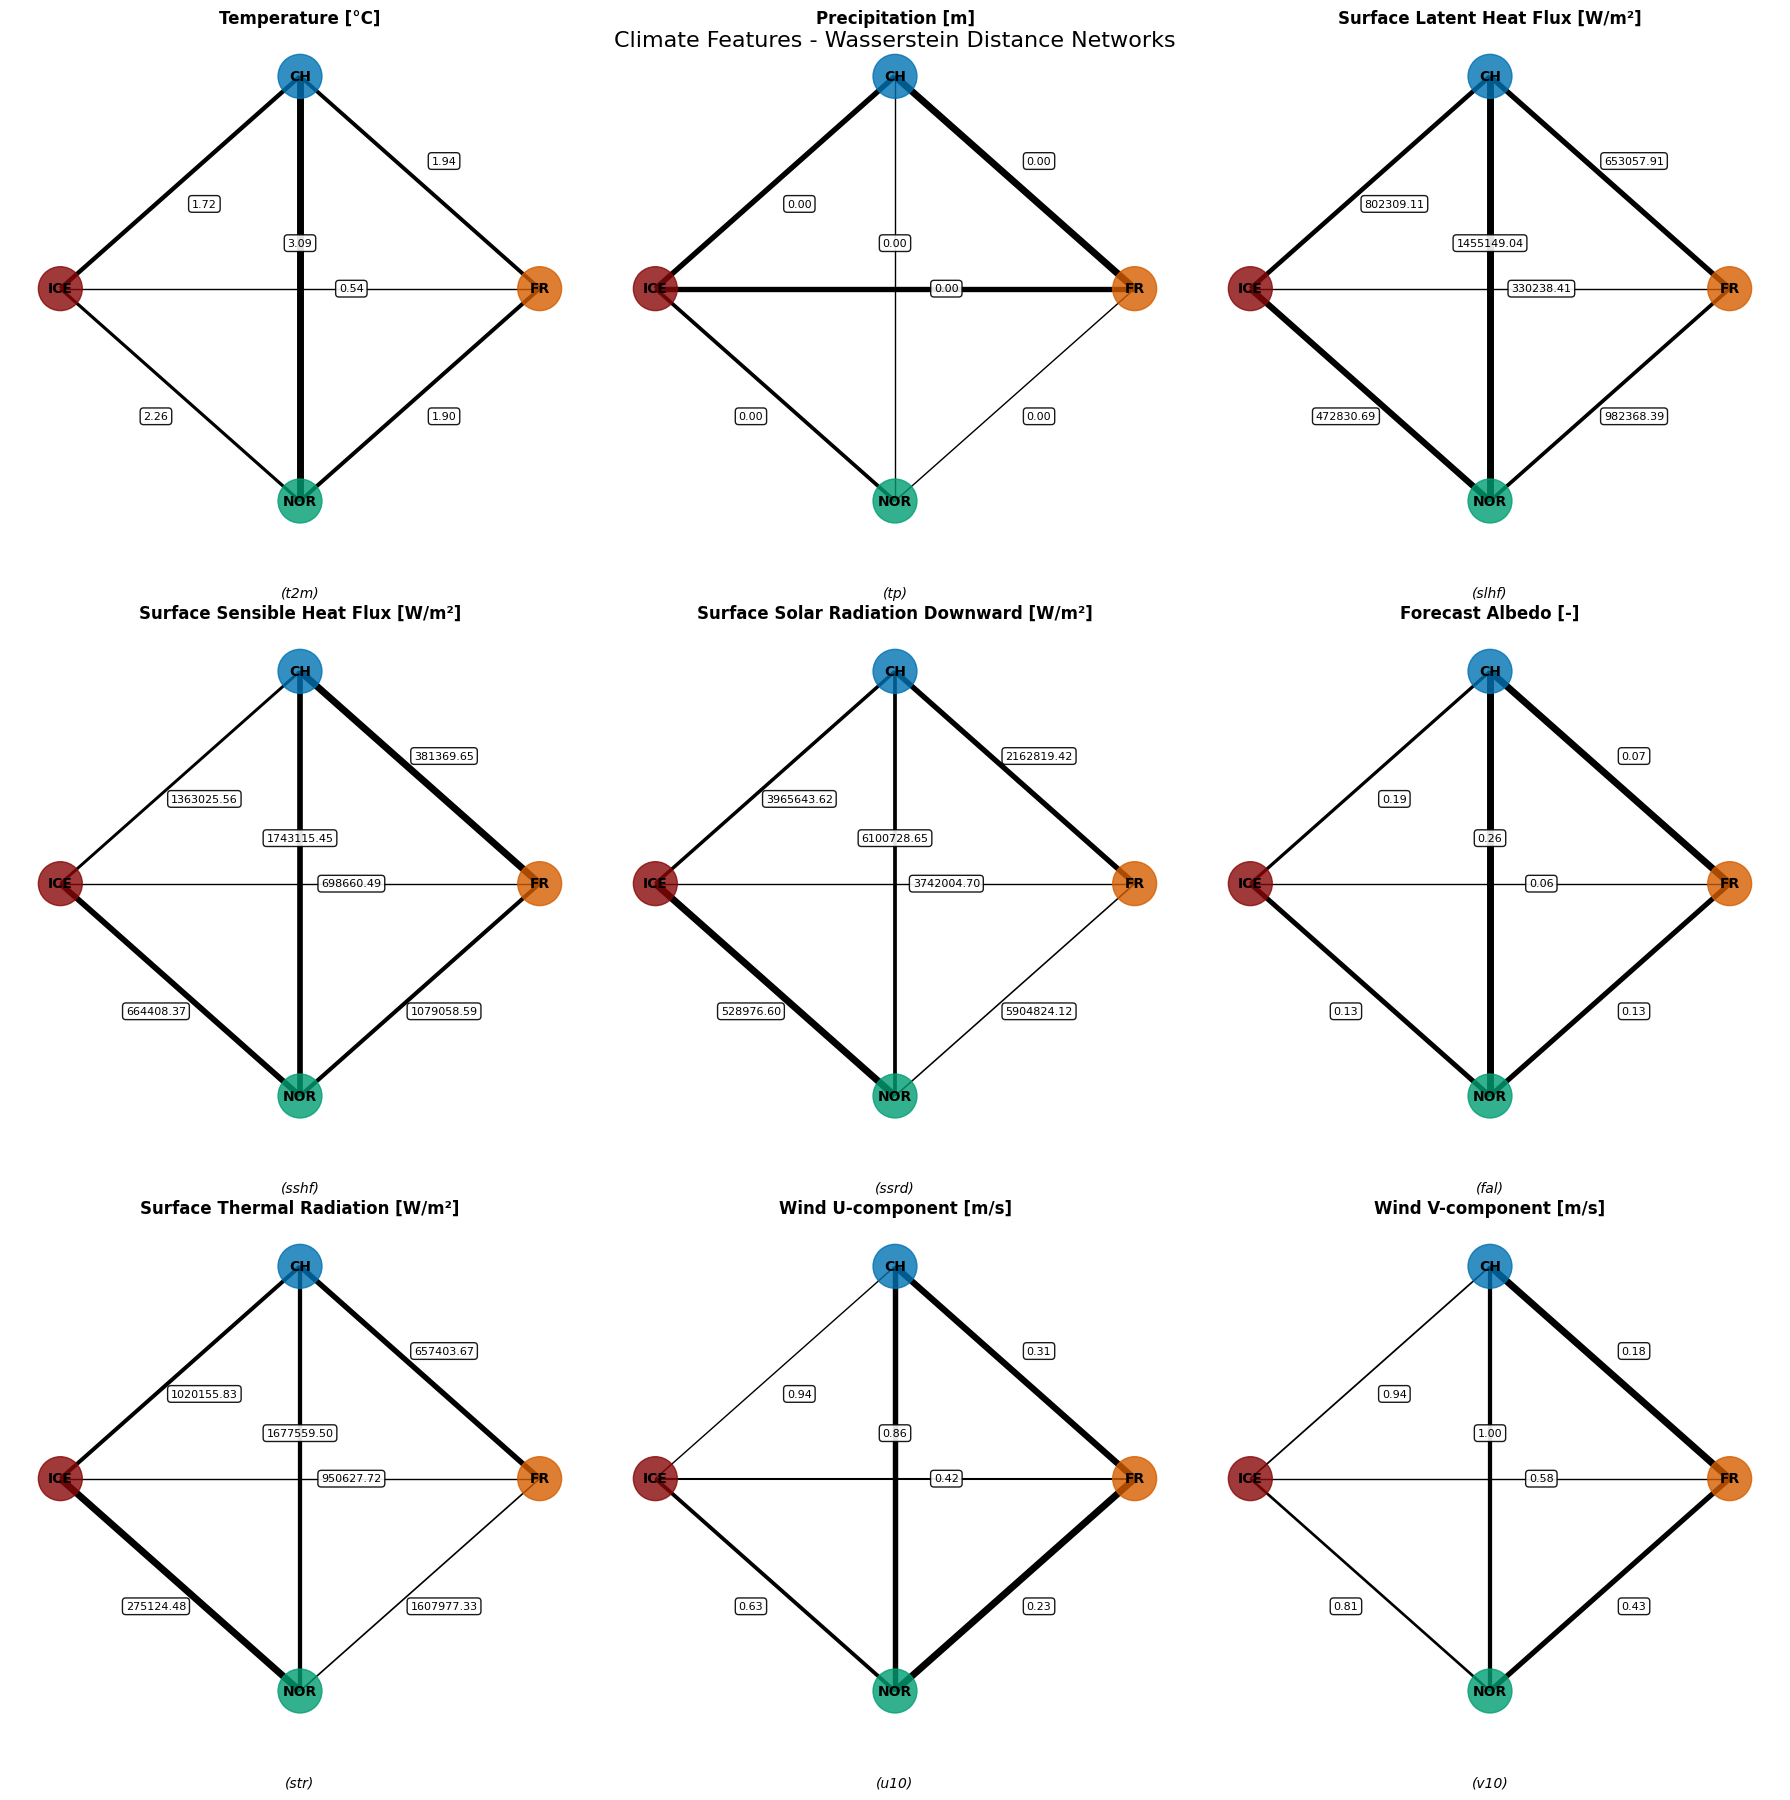

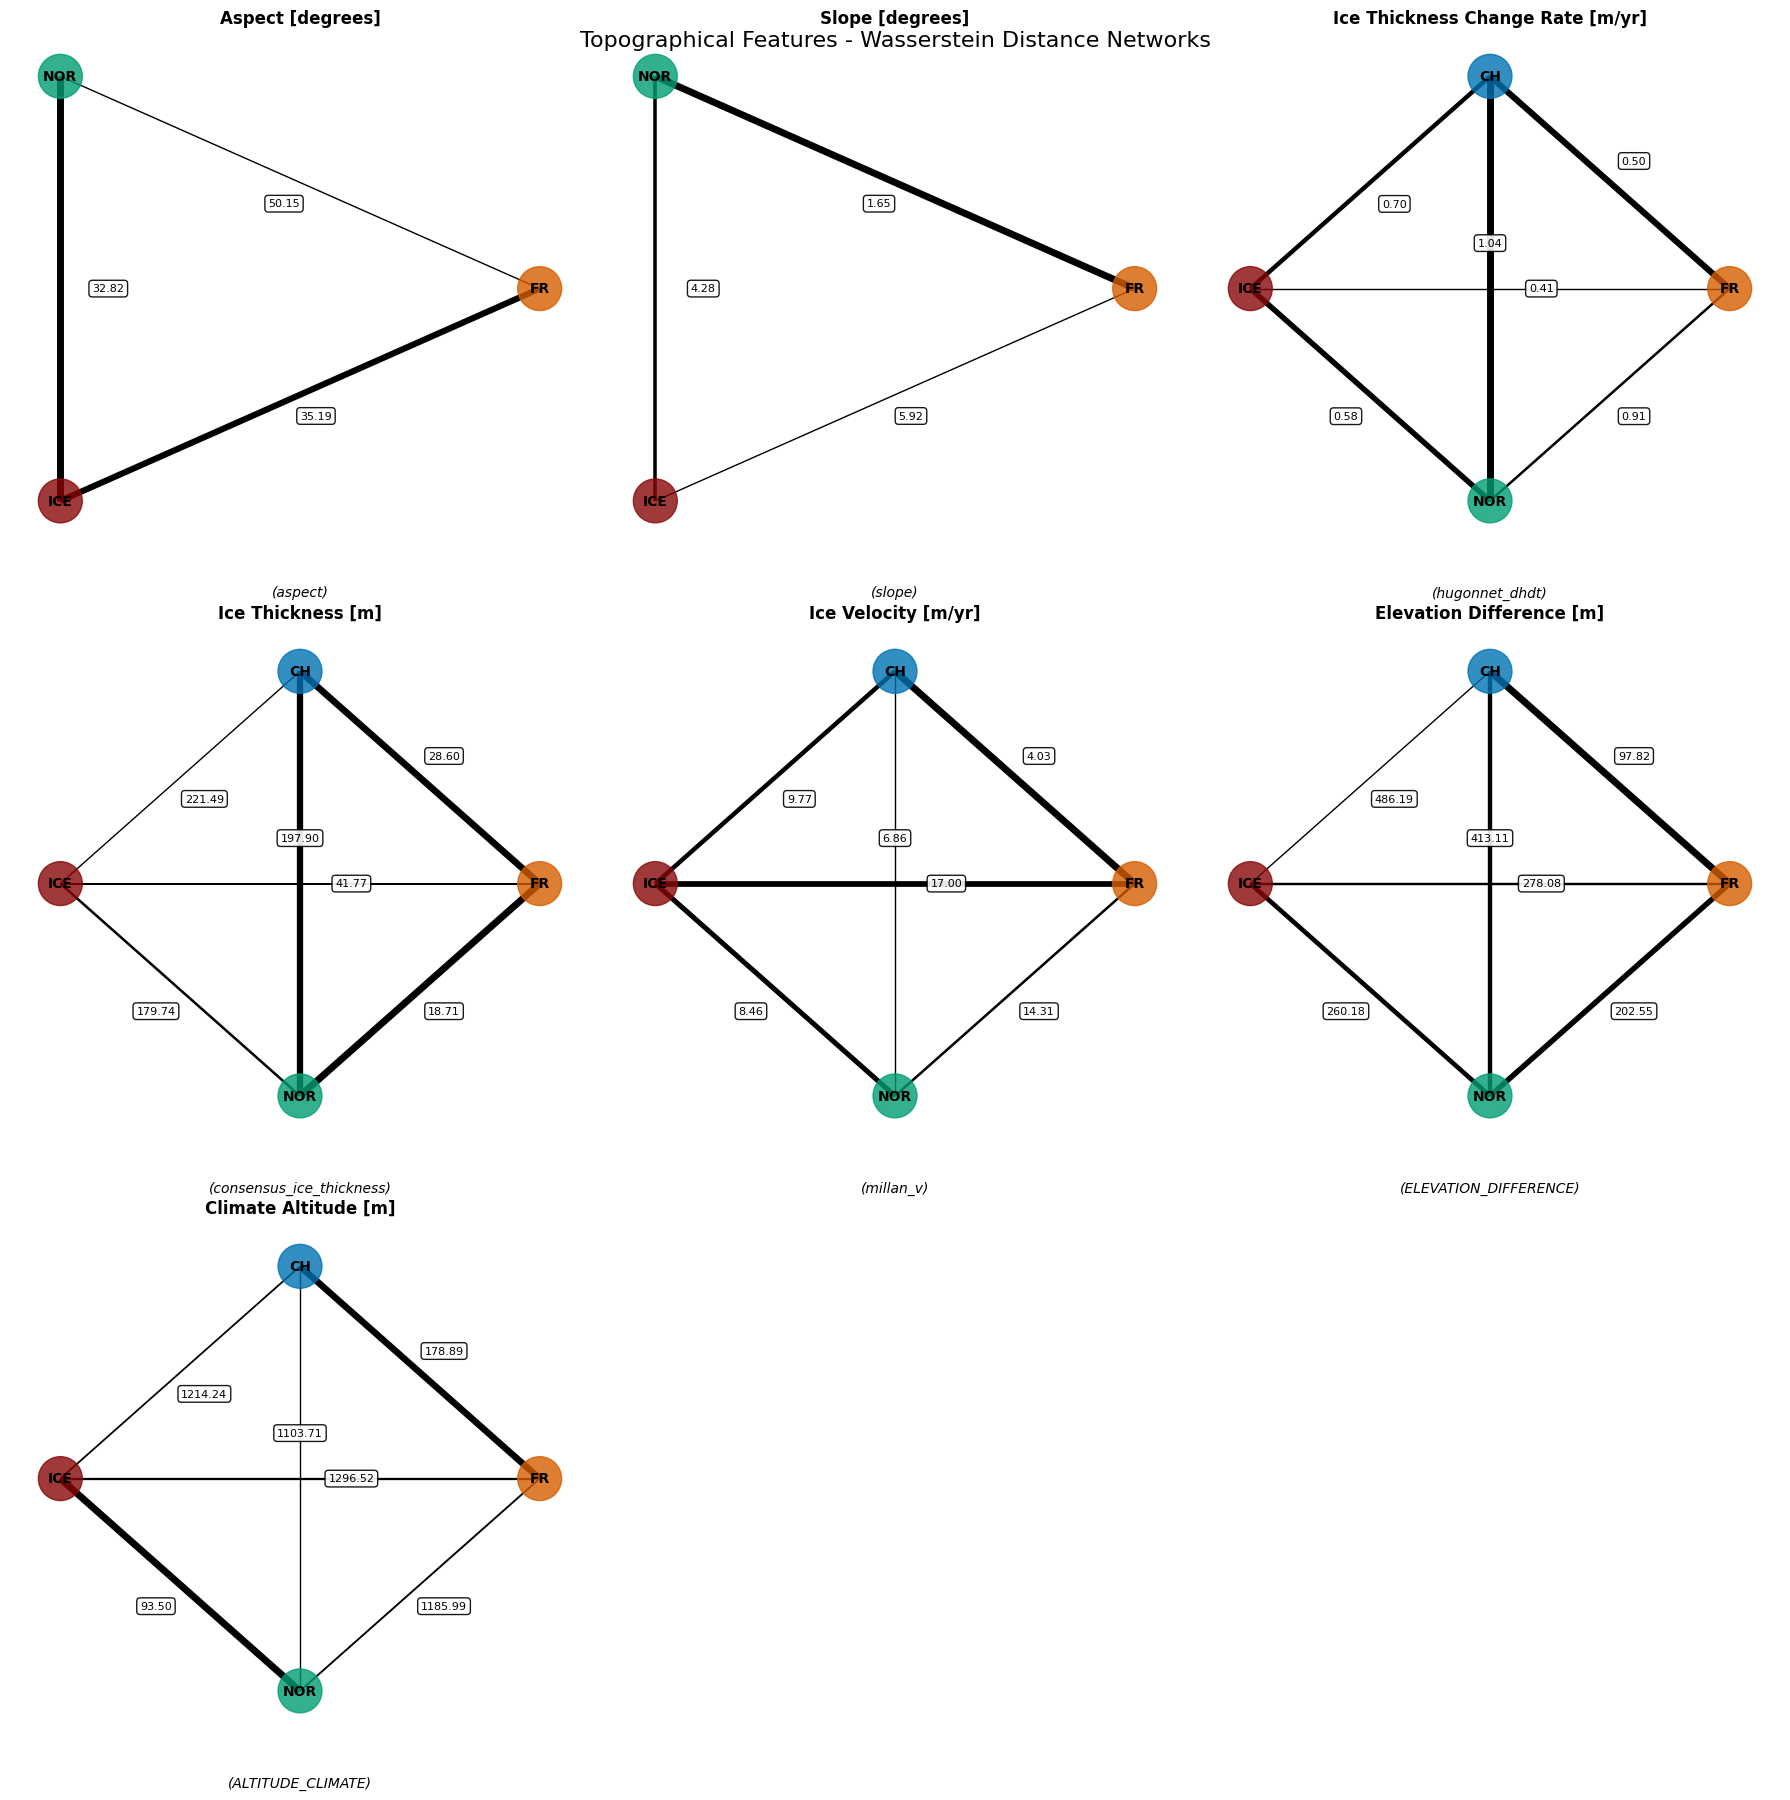

In [ ]:
from scipy.stats import wasserstein_distance
import networkx as nx

def calculate_wasserstein_matrix(datasets, feature):
    # Get regions that have the feature
    available_regions = []
    region_data = {}
    
    for region, df in datasets.items():
        if feature in df.columns:
            data = df[feature].dropna()
            if len(data) > 0:
                available_regions.append(region)
                region_data[region] = data.values
    
    n_regions = len(available_regions)
    distance_matrix = np.zeros((n_regions, n_regions))
    
    # Calculate pairwise Wasserstein distances
    for i, region1 in enumerate(available_regions):
        for j, region2 in enumerate(available_regions):
            if i != j:
                distance = wasserstein_distance(region_data[region1], region_data[region2])
                distance_matrix[i, j] = distance
    
    return distance_matrix, available_regions

def plot_wasserstein_network(datasets, features, feature_labels, title_prefix):
    """Create network plots showing Wasserstein distances for each feature"""
    
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features):
        ax = axes[idx]
        
        if not any(feature in df.columns for df in datasets.values()):
            ax.text(0.5, 0.5, f'Feature "{feature}"\nnot available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{feature_labels.get(feature, feature)}')
            ax.axis('off')
            continue
        
        distance_matrix, regions = calculate_wasserstein_matrix(datasets, feature)
        
        G = nx.Graph()
        for region in regions:
            G.add_node(region)
        
        max_distance = 0
        min_distance = float('inf')
        for i, region1 in enumerate(regions):
            for j, region2 in enumerate(regions):
                if i < j and distance_matrix[i, j] > 0:
                    distance = distance_matrix[i, j]
                    G.add_edge(region1, region2, weight=distance)
                    max_distance = max(max_distance, distance)
                    min_distance = min(min_distance, distance)
        
        if max_distance == 0:
            ax.text(0.5, 0.5, f'No valid distances\nfor "{feature}"', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{feature_labels.get(feature, feature)}')
            ax.axis('off')
            continue
        
        # Diamond layout (equilateral square rotated 45 degrees)
        if len(regions) == 4:
            pos = {
                regions[0]: (0, 0.7),      # top
                regions[1]: (0.7, 0),      # right  
                regions[2]: (0, -0.7),     # bottom
                regions[3]: (-0.7, 0)      # left
            }
        else:
            pos = nx.circular_layout(G)
        
        # Draw nodes
        node_colors = [region_colors[node] for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                              node_size=1000, alpha=0.8, ax=ax)
        
        # Draw edges and labels
        for edge in G.edges(data=True):
            region1, region2, data = edge
            distance = data['weight']
            
            # Thickness: smaller distance = thicker edge (more similar)
            normalized_distance = (distance - min_distance) / (max_distance - min_distance)
            thickness = 1.0 + (1.0 - normalized_distance) * 4.0  # Range: 1-5
            
            nx.draw_networkx_edges(G, pos, edgelist=[(region1, region2)], 
                                 width=thickness, edge_color='black', ax=ax)
            
            # Label positioning
            x1, y1 = pos[region1]
            x2, y2 = pos[region2]
            edge_center_x = (x1 + x2) / 2
            edge_center_y = (y1 + y2) / 2
            
            dx = abs(x2 - x1)
            dy = abs(y2 - y1)
            
            if dx < 0.1:  # Vertical
                label_x = edge_center_x + 0.15
                label_y = edge_center_y
            elif dy < 0.1:  # Horizontal
                label_x = edge_center_x
                label_y = edge_center_y + 0.15
            else:  # Diagonal
                edge_vector = np.array([x2 - x1, y2 - y1])
                perpendicular = np.array([-edge_vector[1], edge_vector[0]]) / np.linalg.norm(edge_vector) * 0.1
                label_x = edge_center_x + perpendicular[0]
                label_y = edge_center_y + perpendicular[1]
            
            ax.text(label_x, label_y, f'{distance:.2f}', 
                   fontsize=8, ha='center', va='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                           alpha=0.9, edgecolor='black', linewidth=1))
        
        nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)
        
        ax.set_title(f'{feature_labels.get(feature, feature)}', fontsize=12, fontweight='bold')
        ax.axis('off')
        ax.text(0.5, -0.1, f'({feature})', transform=ax.transAxes, 
                ha='center', fontsize=10, style='italic')
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'{title_prefix} - Wasserstein Distance Networks', fontsize=16, y=0.98)
    
    return fig

climate_wasserstein_fig = plot_wasserstein_network(datasets, climate_features, feature_labels, 'Climate Features')
plt.show()

topo_wasserstein_fig = plot_wasserstein_network(datasets, topo_features, feature_labels, 'Topographical Features')
plt.show()

Creating comprehensive t-SNE manifold visualizations...


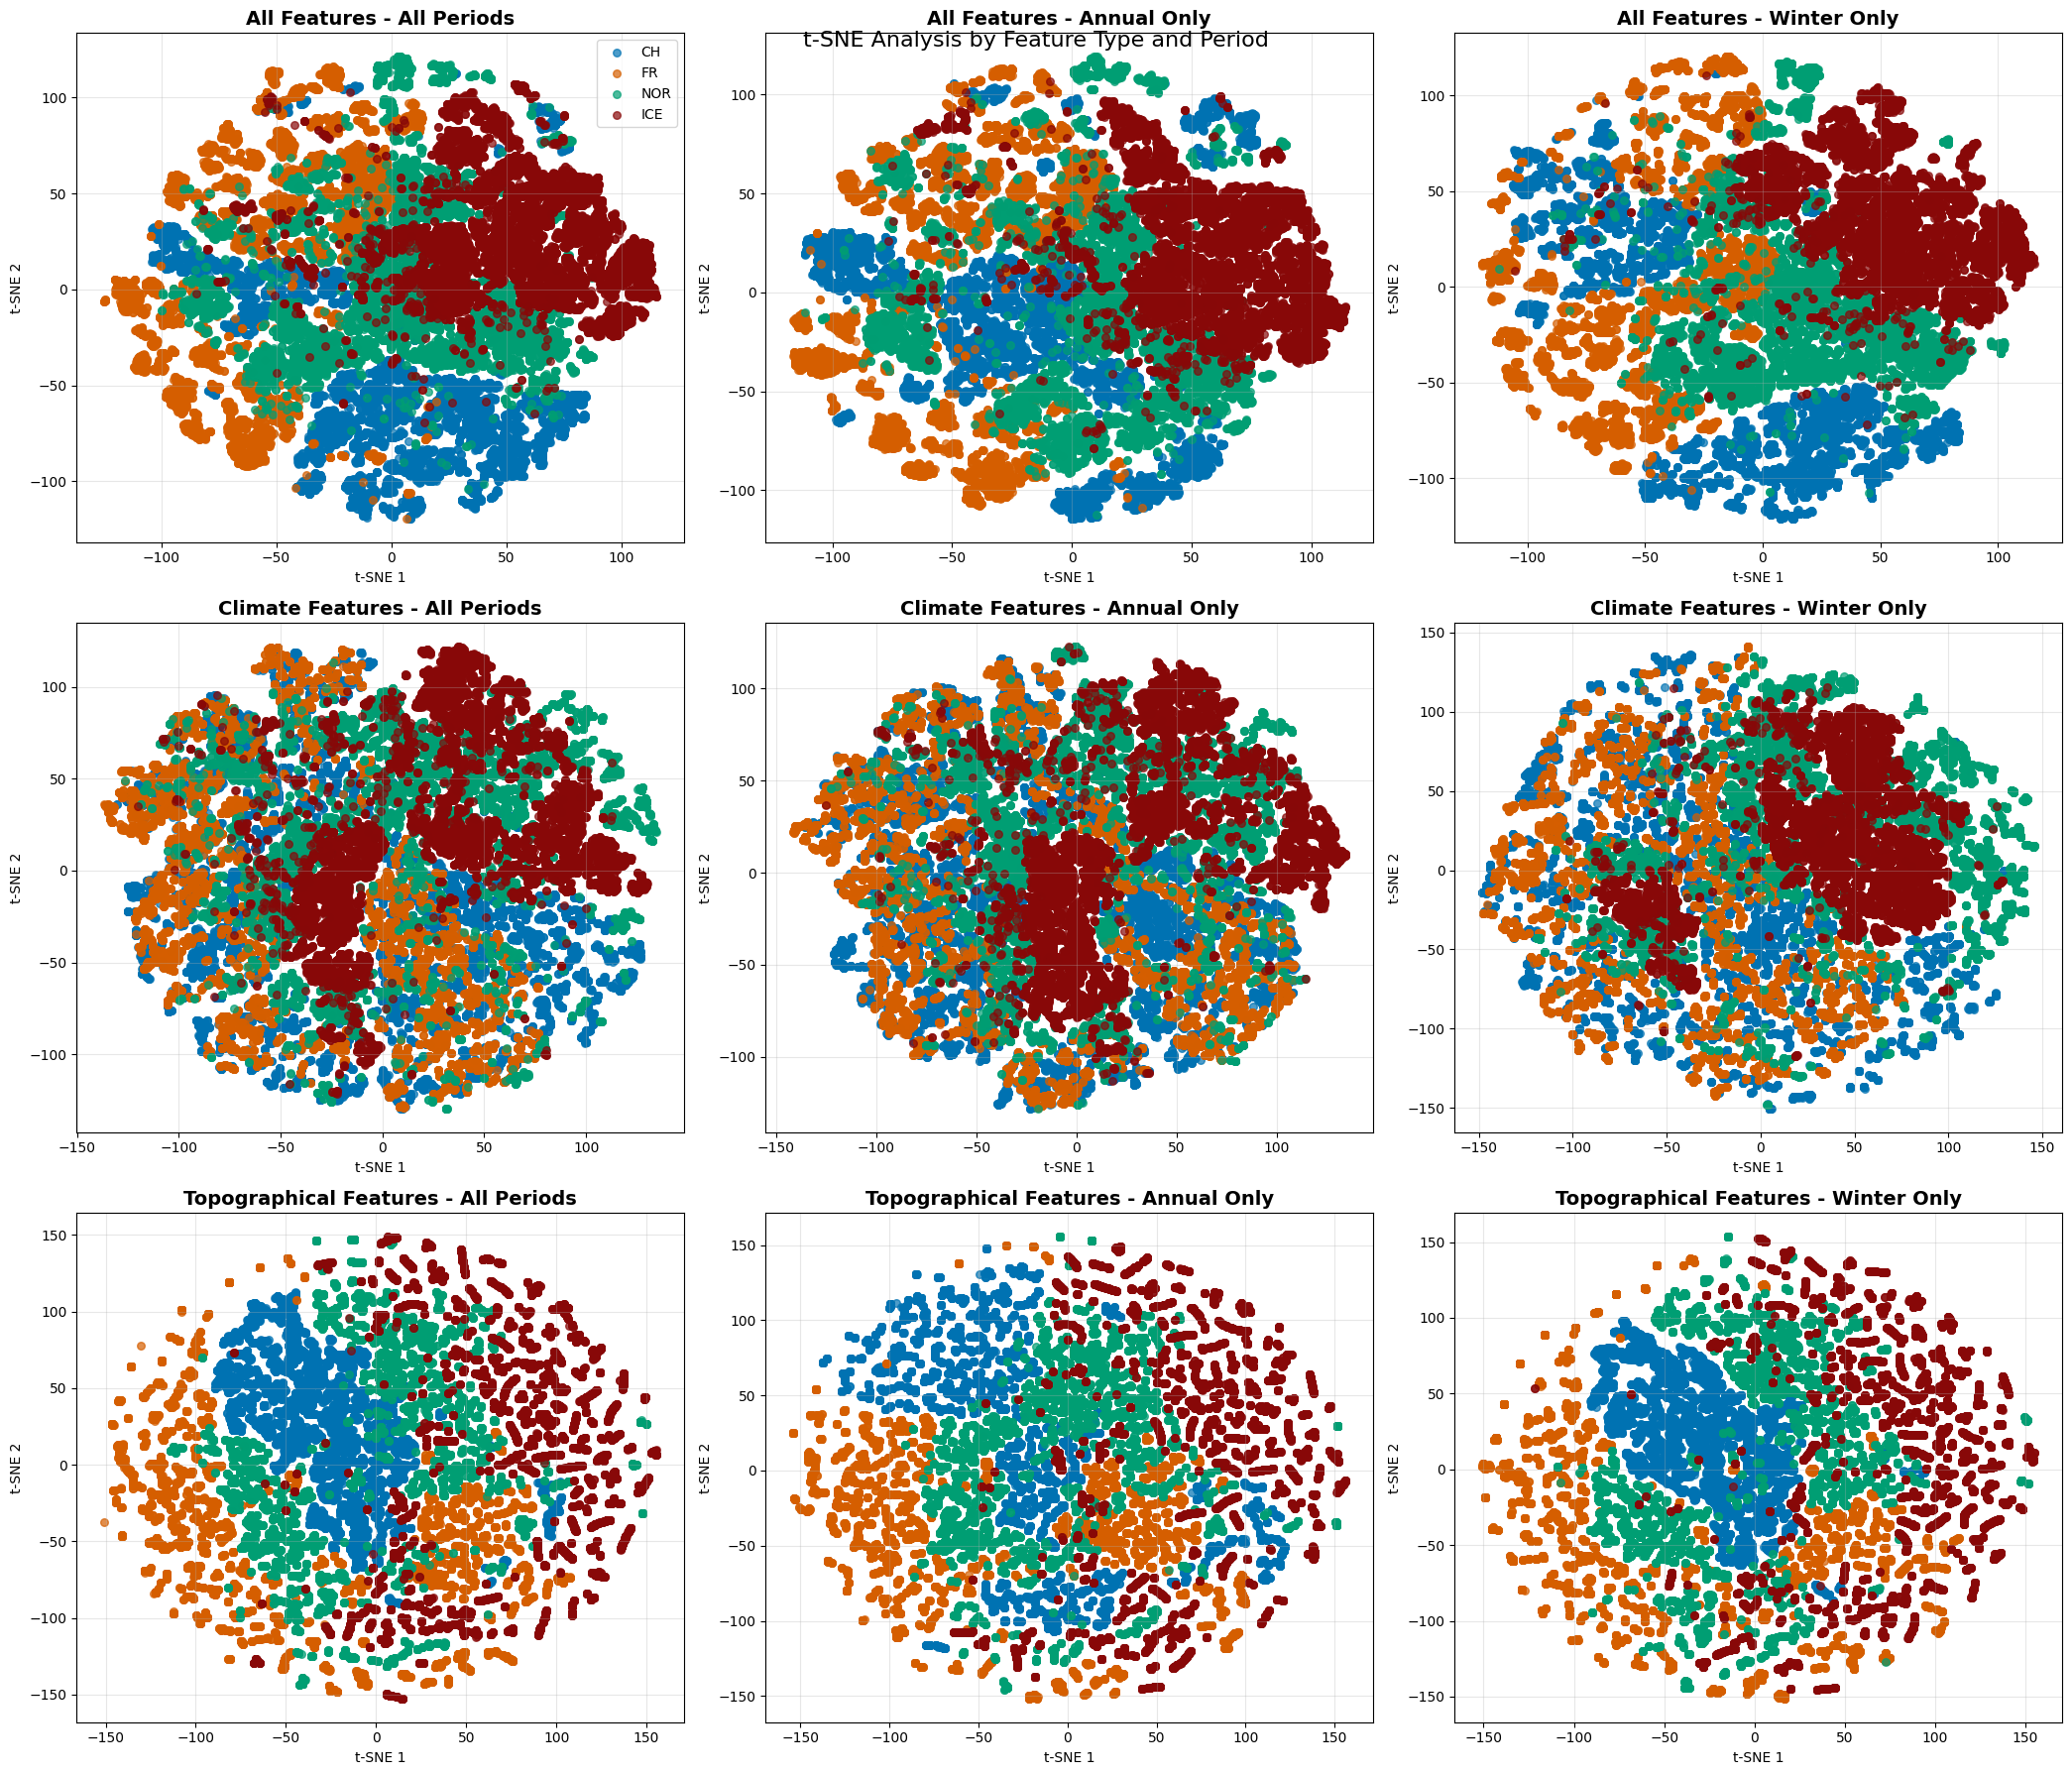

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Manifold Analysis with t-SNE for different periods and feature types
def create_comprehensive_tsne_plots(datasets, climate_features, topo_features):
    """Create comprehensive t-SNE plots for different periods and feature combinations"""
    
    def create_tsne_for_features_and_period(features, feature_type, period_filter=None):
        # Prepare data for manifold learning
        combined_data = []
        region_labels = []
        
        for region, df in datasets.items():
            # Filter by period if specified
            if period_filter:
                df_filtered = df[df['PERIOD'] == period_filter]
            else:
                df_filtered = df
            
            # Select available features
            available_features = [f for f in features if f in df_filtered.columns]
            
            if len(available_features) > 0:
                region_data = df_filtered[available_features].dropna()
                
                if len(region_data) > 0:
                    # Sample data to 10000 to not have too long of an execute time
                    if len(region_data) > 10000:
                        region_data = region_data.sample(n=10000, random_state=20)
                    
                    combined_data.append(region_data)
                    region_labels.extend([region] * len(region_data))
        
        if not combined_data:
            return None, None
        
        # Concatenate all data
        full_data = pd.concat(combined_data, ignore_index=True)
        full_data = full_data.fillna(full_data.median())
        
        # Normalize the data
        scaler = StandardScaler()
        normalized_data = scaler.fit_transform(full_data)
        
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=20, perplexity=min(30, len(normalized_data)//4))
        tsne_result = tsne.fit_transform(normalized_data)
        
        return tsne_result, region_labels
    
    fig, axes = plt.subplots(3, 3, figsize=(21, 18))
    
    # Row 1: All features
    all_features = climate_features + topo_features
    periods = [None, 'annual', 'winter']
    period_titles = ['All Periods', 'Annual Only', 'Winter Only']
    
    for col, (period, period_title) in enumerate(zip(periods, period_titles)):
        ax = axes[0, col]
        tsne_result, region_labels = create_tsne_for_features_and_period(all_features, "All", period)
        
        if tsne_result is not None:
            for region in region_colors.keys():
                mask = np.array(region_labels) == region
                if np.any(mask):
                    ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                             c=region_colors[region], label=region, alpha=0.7, s=30)
        
        ax.set_title(f'All Features - {period_title}', fontsize=14, fontweight='bold')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        if col == 0:  # Only show legend on first plot
            ax.legend()
        ax.grid(alpha=0.3)
    
    # Row 2: Climate features only
    for col, (period, period_title) in enumerate(zip(periods, period_titles)):
        ax = axes[1, col]
        tsne_result, region_labels = create_tsne_for_features_and_period(climate_features, "Climate", period)
        
        if tsne_result is not None:
            for region in region_colors.keys():
                mask = np.array(region_labels) == region
                if np.any(mask):
                    ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                             c=region_colors[region], label=region, alpha=0.7, s=30)
        
        ax.set_title(f'Climate Features - {period_title}', fontsize=14, fontweight='bold')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.grid(alpha=0.3)
    
    # Row 3: Topographical features only
    for col, (period, period_title) in enumerate(zip(periods, period_titles)):
        ax = axes[2, col]
        tsne_result, region_labels = create_tsne_for_features_and_period(topo_features, "Topographical", period)
        
        if tsne_result is not None:
            for region in region_colors.keys():
                mask = np.array(region_labels) == region
                if np.any(mask):
                    ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                             c=region_colors[region], label=region, alpha=0.7, s=30)
        
        ax.set_title(f'Topographical Features - {period_title}', fontsize=14, fontweight='bold')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('t-SNE Analysis by Feature Type and Period', fontsize=16, y=0.98)
    return fig

print("Creating comprehensive t-SNE manifold visualizations...")
comprehensive_tsne_fig = create_comprehensive_tsne_plots(datasets, climate_features, topo_features)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def create_tsne_for_features_and_period_stratified(features, feature_type, period_filter=None, points_per_glacier=100):
    """Create t-SNE with stratified sampling by glacier"""
    combined_data = []
    region_labels = []
    glacier_labels = []
    
    for region, df in datasets.items():
        # Filter by period if specified
        if period_filter:
            df_filtered = df[df['PERIOD'] == period_filter]
        else:
            df_filtered = df
        
        # Select available features
        available_features = [f for f in features if f in df_filtered.columns]
        
        if len(available_features) > 0:
            # Sample by glacier
            region_data_list = []
            for glacier in df_filtered['GLACIER'].unique():
                glacier_data = df_filtered[df_filtered['GLACIER'] == glacier][available_features].dropna()
                
                if len(glacier_data) > 0:
                    # Sample up to points_per_glacier from each glacier
                    n_sample = min(points_per_glacier, len(glacier_data))
                    sampled_data = glacier_data.sample(n=n_sample, random_state=20)
                    region_data_list.append(sampled_data)
                    
                    # Track glacier labels for each sample
                    glacier_labels.extend([f"{region}_{glacier}"] * len(sampled_data))
            
            if region_data_list:
                region_data = pd.concat(region_data_list, ignore_index=True)
                combined_data.append(region_data)
                region_labels.extend([region] * len(region_data))
    
    if not combined_data:
        return None, None, None
    
    # Continue with t-SNE as before...
    full_data = pd.concat(combined_data, ignore_index=True)
    full_data = full_data.fillna(full_data.median())
    
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(full_data)

    tsne = TSNE(n_components=2, random_state=20, perplexity=30)
    tsne_result = tsne.fit_transform(normalized_data)
    
    return tsne_result, region_labels, glacier_labels

def create_balanced_sample(datasets, features, total_samples=5000, period_filter=None):
    """Create a balanced sample that represents each glacier proportionally"""
    all_samples = []
    
    for region, df in datasets.items():
        if period_filter:
            df_filtered = df[df['PERIOD'] == period_filter]
        else:
            df_filtered = df
        
        available_features = [f for f in features if f in df_filtered.columns]
        region_data = df_filtered[available_features + ['GLACIER']].dropna()
        
        if len(region_data) > 0:
            # Calculate samples per glacier based on region size
            region_samples = int(total_samples * len(region_data) / sum(len(datasets[r]) for r in datasets))
            glacier_counts = region_data['GLACIER'].value_counts()
            
            glacier_samples = []
            for glacier, count in glacier_counts.items():
                # Proportional sampling within region
                glacier_sample_size = max(1, int(region_samples * count / len(region_data)))
                glacier_data = region_data[region_data['GLACIER'] == glacier]
                
                sample_size = min(glacier_sample_size, len(glacier_data))
                sampled = glacier_data.sample(n=sample_size, random_state=20)
                glacier_samples.append(sampled)
            
            if glacier_samples:
                region_sample = pd.concat(glacier_samples, ignore_index=True)
                region_sample['region'] = region
                all_samples.append(region_sample)
    
    return pd.concat(all_samples, ignore_index=True) if all_samples else None

def create_comprehensive_tsne_plots_improved(datasets, climate_features, topo_features, sampling_method='stratified'):
    """Create comprehensive t-SNE plots with improved sampling strategies"""
    
    def create_tsne_with_sampling(features, feature_type, period_filter=None):
        if sampling_method == 'stratified':
            # Use 30-50 points per glacier for balanced representation
            return create_tsne_for_features_and_period_stratified(features, feature_type, period_filter)
        else:
            # Use balanced proportional sampling
            sample_data = create_balanced_sample(datasets, features, total_samples=10000, period_filter=period_filter)
            if sample_data is None:
                return None, None, None
            
            # Prepare for t-SNE
            feature_data = sample_data[features].fillna(sample_data[features].median())
            region_labels = sample_data['region'].tolist()
            glacier_labels = sample_data.apply(lambda x: f"{x['region']}_{x['GLACIER']}", axis=1).tolist()
            
            scaler = StandardScaler()
            normalized_data = scaler.fit_transform(feature_data)
            
            tsne = TSNE(n_components=2, random_state=20, perplexity=min(30, len(normalized_data)//4))
            tsne_result = tsne.fit_transform(normalized_data)
            
            return tsne_result, region_labels, glacier_labels
    
    fig, axes = plt.subplots(3, 3, figsize=(21, 18))

    
    all_features = climate_features + topo_features
    periods = [None, 'annual', 'winter']
    period_titles = ['All Periods', 'Annual Only', 'Winter Only']
    
    for row, (features, feature_name) in enumerate([(all_features, 'All'), (climate_features, 'Climate'), (topo_features, 'Topographical')]):
        for col, (period, period_title) in enumerate(zip(periods, period_titles)):
            ax = axes[row, col]
            tsne_result, region_labels, glacier_labels = create_tsne_with_sampling(features, feature_name, period)
            
            if tsne_result is not None:
                # Plot by region
                for region in region_colors.keys():
                    mask = np.array(region_labels) == region
                    if np.any(mask):
                        ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                                 c=region_colors[region], label=region, alpha=0.7, s=30)
            
            ax.set_title(f'{feature_name} Features - {period_title}', fontsize=14, fontweight='bold')
            ax.set_xlabel('t-SNE 1')
            ax.set_ylabel('t-SNE 2')
            if row == 0 and col == 0:  # Only show legend once
                ax.legend()
            ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

stratified_fig = create_comprehensive_tsne_plots_improved(datasets, climate_features, topo_features, sampling_method='stratified')
plt.show()

#proportional_fig = create_comprehensive_tsne_plots_improved(datasets, climate_features, topo_features, sampling_method='proportional')
#plt.show()

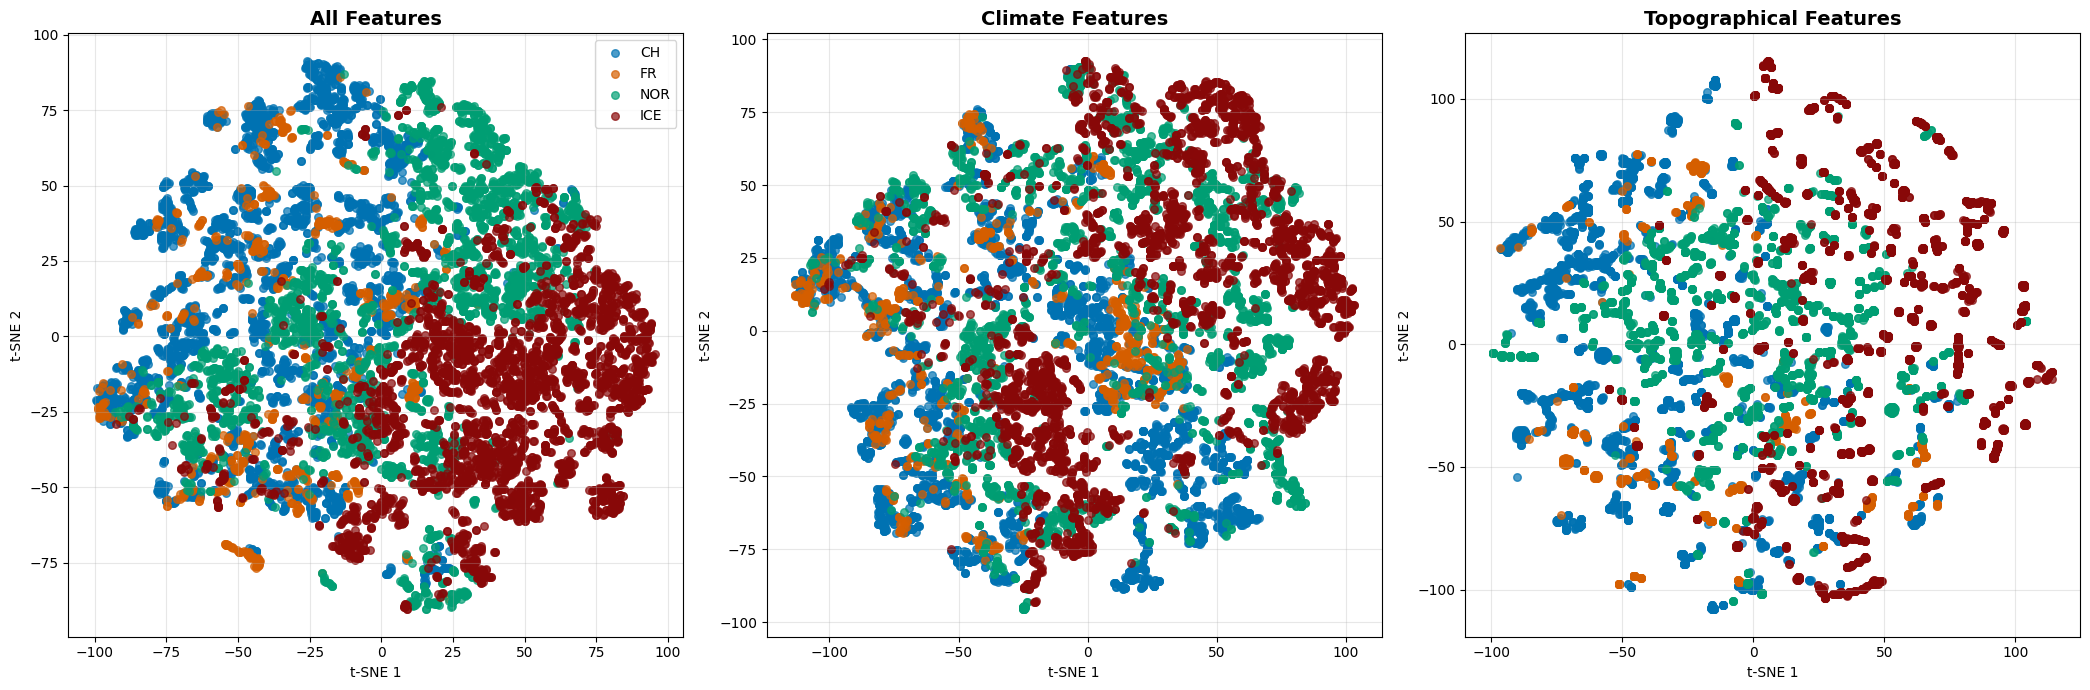

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def create_tsne_for_features_and_period_stratified(features, feature_type, period_filter=None, points_per_glacier=100):
    """Create t-SNE with stratified sampling by glacier"""
    combined_data = []
    region_labels = []
    glacier_labels = []
    
    for region, df in datasets.items():
        # Filter by period if specified
        if period_filter:
            df_filtered = df[df['PERIOD'] == period_filter]
        else:
            df_filtered = df
        
        # Select available features
        available_features = [f for f in features if f in df_filtered.columns]
        
        if len(available_features) > 0:
            # Sample by glacier
            region_data_list = []
            for glacier in df_filtered['GLACIER'].unique():
                glacier_data = df_filtered[df_filtered['GLACIER'] == glacier][available_features].dropna()
                
                if len(glacier_data) > 0:
                    # Sample up to points_per_glacier from each glacier
                    n_sample = min(points_per_glacier, len(glacier_data))
                    sampled_data = glacier_data.sample(n=n_sample, random_state=20)
                    region_data_list.append(sampled_data)
                    
                    # Track glacier labels for each sample
                    glacier_labels.extend([f"{region}_{glacier}"] * len(sampled_data))
            
            if region_data_list:
                region_data = pd.concat(region_data_list, ignore_index=True)
                combined_data.append(region_data)
                region_labels.extend([region] * len(region_data))
    
    if not combined_data:
        return None, None, None
    
    # Continue with t-SNE as before...
    full_data = pd.concat(combined_data, ignore_index=True)
    full_data = full_data.fillna(full_data.median())
    
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(full_data)

    tsne = TSNE(n_components=2, random_state=20, perplexity=30)
    tsne_result = tsne.fit_transform(normalized_data)
    
    return tsne_result, region_labels, glacier_labels

def create_comprehensive_tsne_plots_improved(datasets, climate_features, topo_features, sampling_method='stratified'):
    """Create comprehensive t-SNE plots with improved sampling strategies"""
    
    def create_tsne_with_sampling(features, feature_type, period_filter=None):
        if sampling_method == 'stratified':
            return create_tsne_for_features_and_period_stratified(features, feature_type, period_filter)

    fig, axes = plt.subplots(1, 3, figsize=(21, 7))  # 1 row, 3 columns

    
    all_features = climate_features + topo_features
    periods = [None]
    period_titles = ['All Periods', 'Annual Only', 'Winter Only']
    
    for row, (features, feature_name) in enumerate([(all_features, 'All'), (climate_features, 'Climate'), (topo_features, 'Topographical')]):
        col = 0  # only one column
        ax = axes[row]
        tsne_result, region_labels, glacier_labels = create_tsne_with_sampling(features, feature_name, periods[col])
    
        if tsne_result is not None:
            # Plot by region
            for region in region_colors.keys():
                mask = np.array(region_labels) == region
                if np.any(mask):
                    ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                                c=region_colors[region], label=region, alpha=0.7, s=30)
        
        ax.set_title(f'{feature_name} Features', fontsize=14, fontweight='bold')
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        if row == 0 and col == 0:  # Only show legend once
            ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    return fig

stratified_fig = create_comprehensive_tsne_plots_improved(datasets, climate_features, topo_features, sampling_method='stratified')
plt.show()

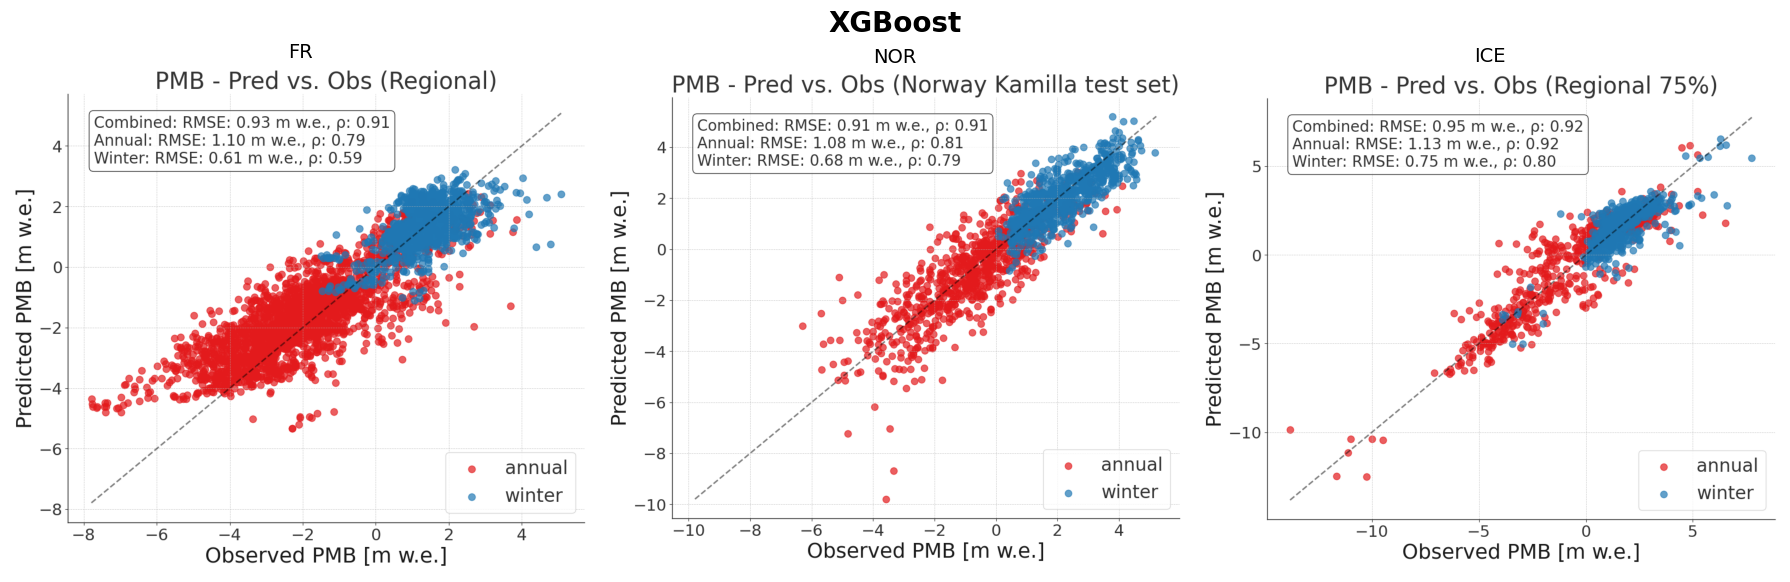

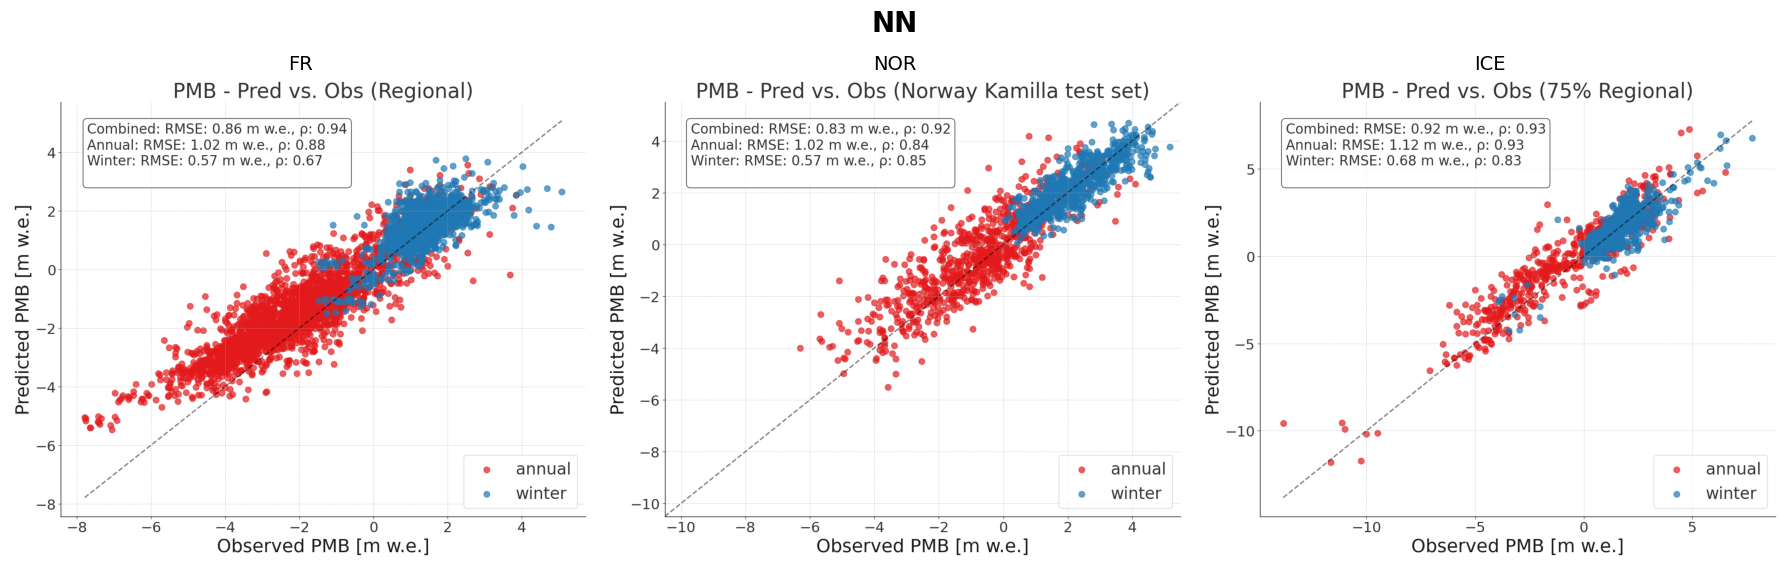

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_three_pngs(paths, titles=None, fig_title=None, figsize=(15,5)):
    assert len(paths) == 3, "Provide exactly 3 image paths"
    if titles is None:
        titles = [""] * 3

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for ax, p, t in zip(axes, paths, titles):
        img = mpimg.imread(p)
        ax.imshow(img)
        ax.set_title(t, fontsize=14)
        ax.axis('off')
    fig.suptitle(fig_title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage - replace with your actual png paths
paths_xgb = [
    '/home/mburlet/scratch/data/DATA_MB/Outputs/France_50%_3glaciers/XGBoost_widerparam_lr0.01_depth3_estim800/7.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Norway_Kamilla(trainset_is_ca_75%)/XGBoost_with_millan_v_lr0_1_depth_5_nestimators_700/7.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Iceland_regional_75%_lr0_01_n_estimators_700_depth_8/7.png'
]
paths_nn = [
    '/home/mburlet/scratch/data/DATA_MB/Outputs/France_50%_3glaciers/NN/Flexible/4.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Norway_Kamilla(trainset_is_ca_75%)/NN/flexible/4_axisfixed.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Iceland_regional_75%_lr0_01_n_estimators_700_depth_8/NN/Flexible/4.png'
]

titles = ['FR', 'NOR', 'ICE']
plot_three_pngs(paths_xgb, titles, fig_title='XGBoost', figsize=(18,6))
plot_three_pngs(paths_nn, titles, fig_title='NN', figsize=(18,6))

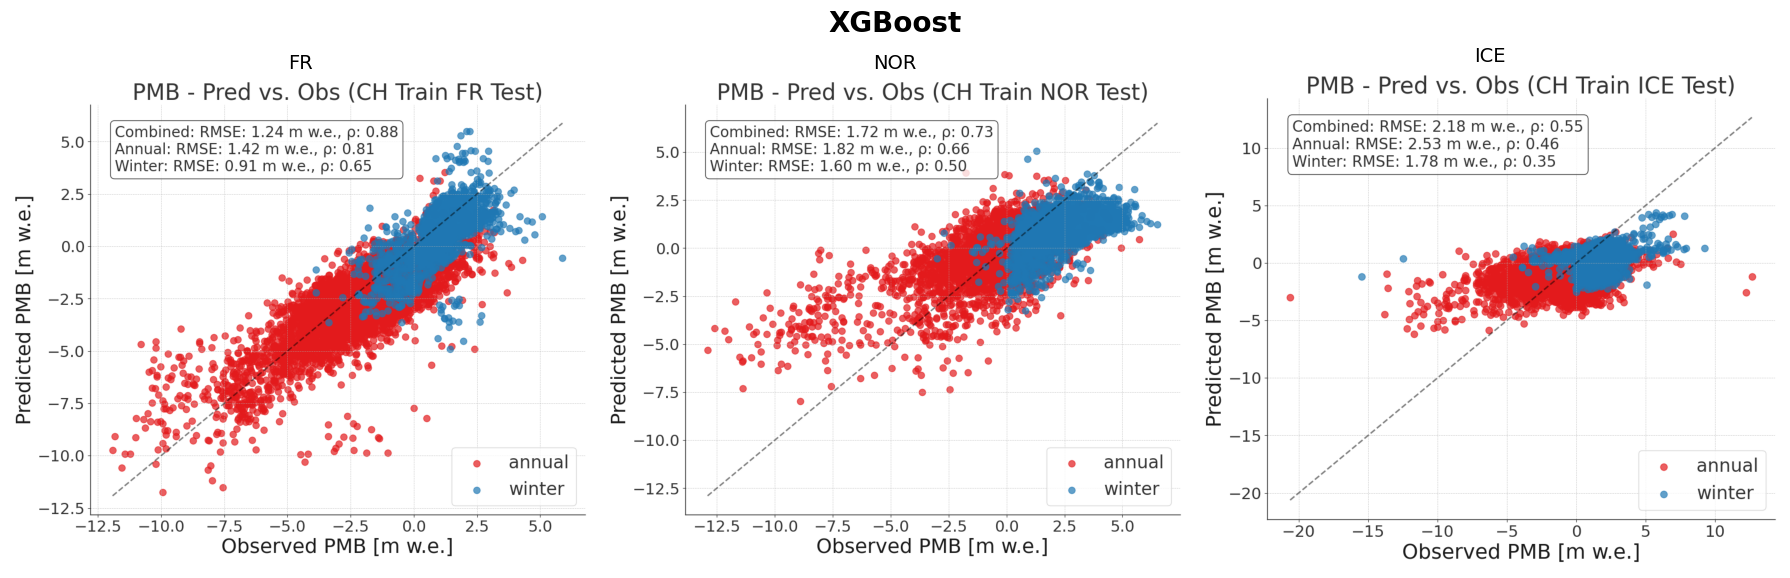

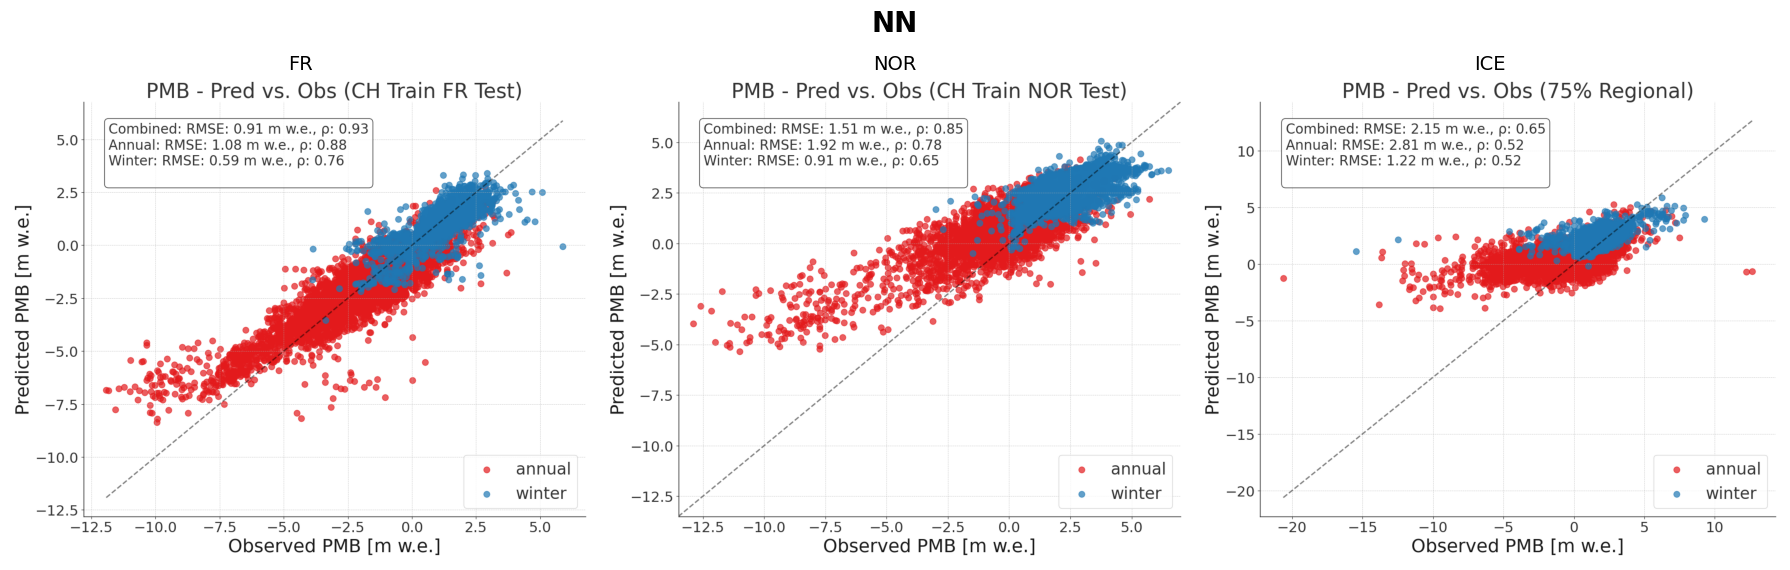

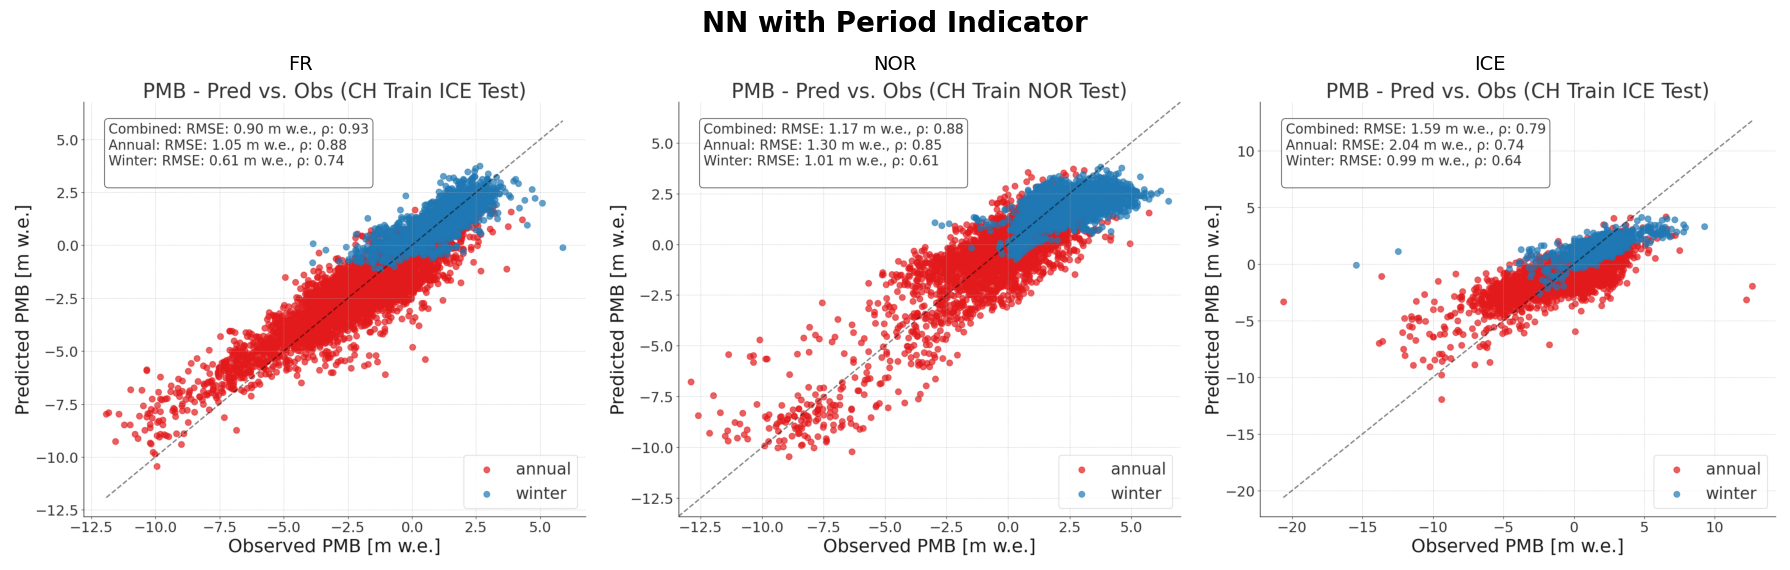

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_three_pngs(paths, titles=None, fig_title=None, figsize=(15,5)):
    assert len(paths) == 3, "Provide exactly 3 image paths"
    if titles is None:
        titles = [""] * 3

    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for ax, p, t in zip(axes, paths, titles):
        img = mpimg.imread(p)
        ax.imshow(img)
        ax.set_title(t, fontsize=14)
        ax.axis('off')
    fig.suptitle(fig_title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Example usage - replace with your actual png paths
paths_xgb = [
    '/home/mburlet/scratch/data/DATA_MB/Outputs/France_Swiss/xgb_CH_FR_06_09_wideparamsearch_with_blanc/7.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Norway_Swiss/7.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Iceland_Swiss/7.png'
]
paths_nn = [
    '/home/mburlet/scratch/data/DATA_MB/Outputs/France_Swiss/NN/Flexible/4.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Norway_Swiss/NN/Flexible/4.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Iceland_Swiss/NN/Flexible/4.png'
]

paths_nn_period = [
    '/home/mburlet/scratch/data/DATA_MB/Outputs/France_Swiss/NN/nn_model_2025-07-14_CH_flexible_periodindicator/4.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Norway_Swiss/NN/nn_model_2025-07-14_CH_flexible_periodindicator/4.png',
    '/home/mburlet/scratch/data/DATA_MB/Outputs/Iceland_Swiss/NN/nn_model_2025-07-14_CH_flexible_periodindicator/4.png'
]

titles = ['FR', 'NOR', 'ICE']
plot_three_pngs(paths_xgb, titles, fig_title='XGBoost', figsize=(18,6))
plot_three_pngs(paths_nn, titles, fig_title='NN', figsize=(18,6))
plot_three_pngs(paths_nn_period, titles, fig_title='NN with Period Indicator', figsize=(18,6))

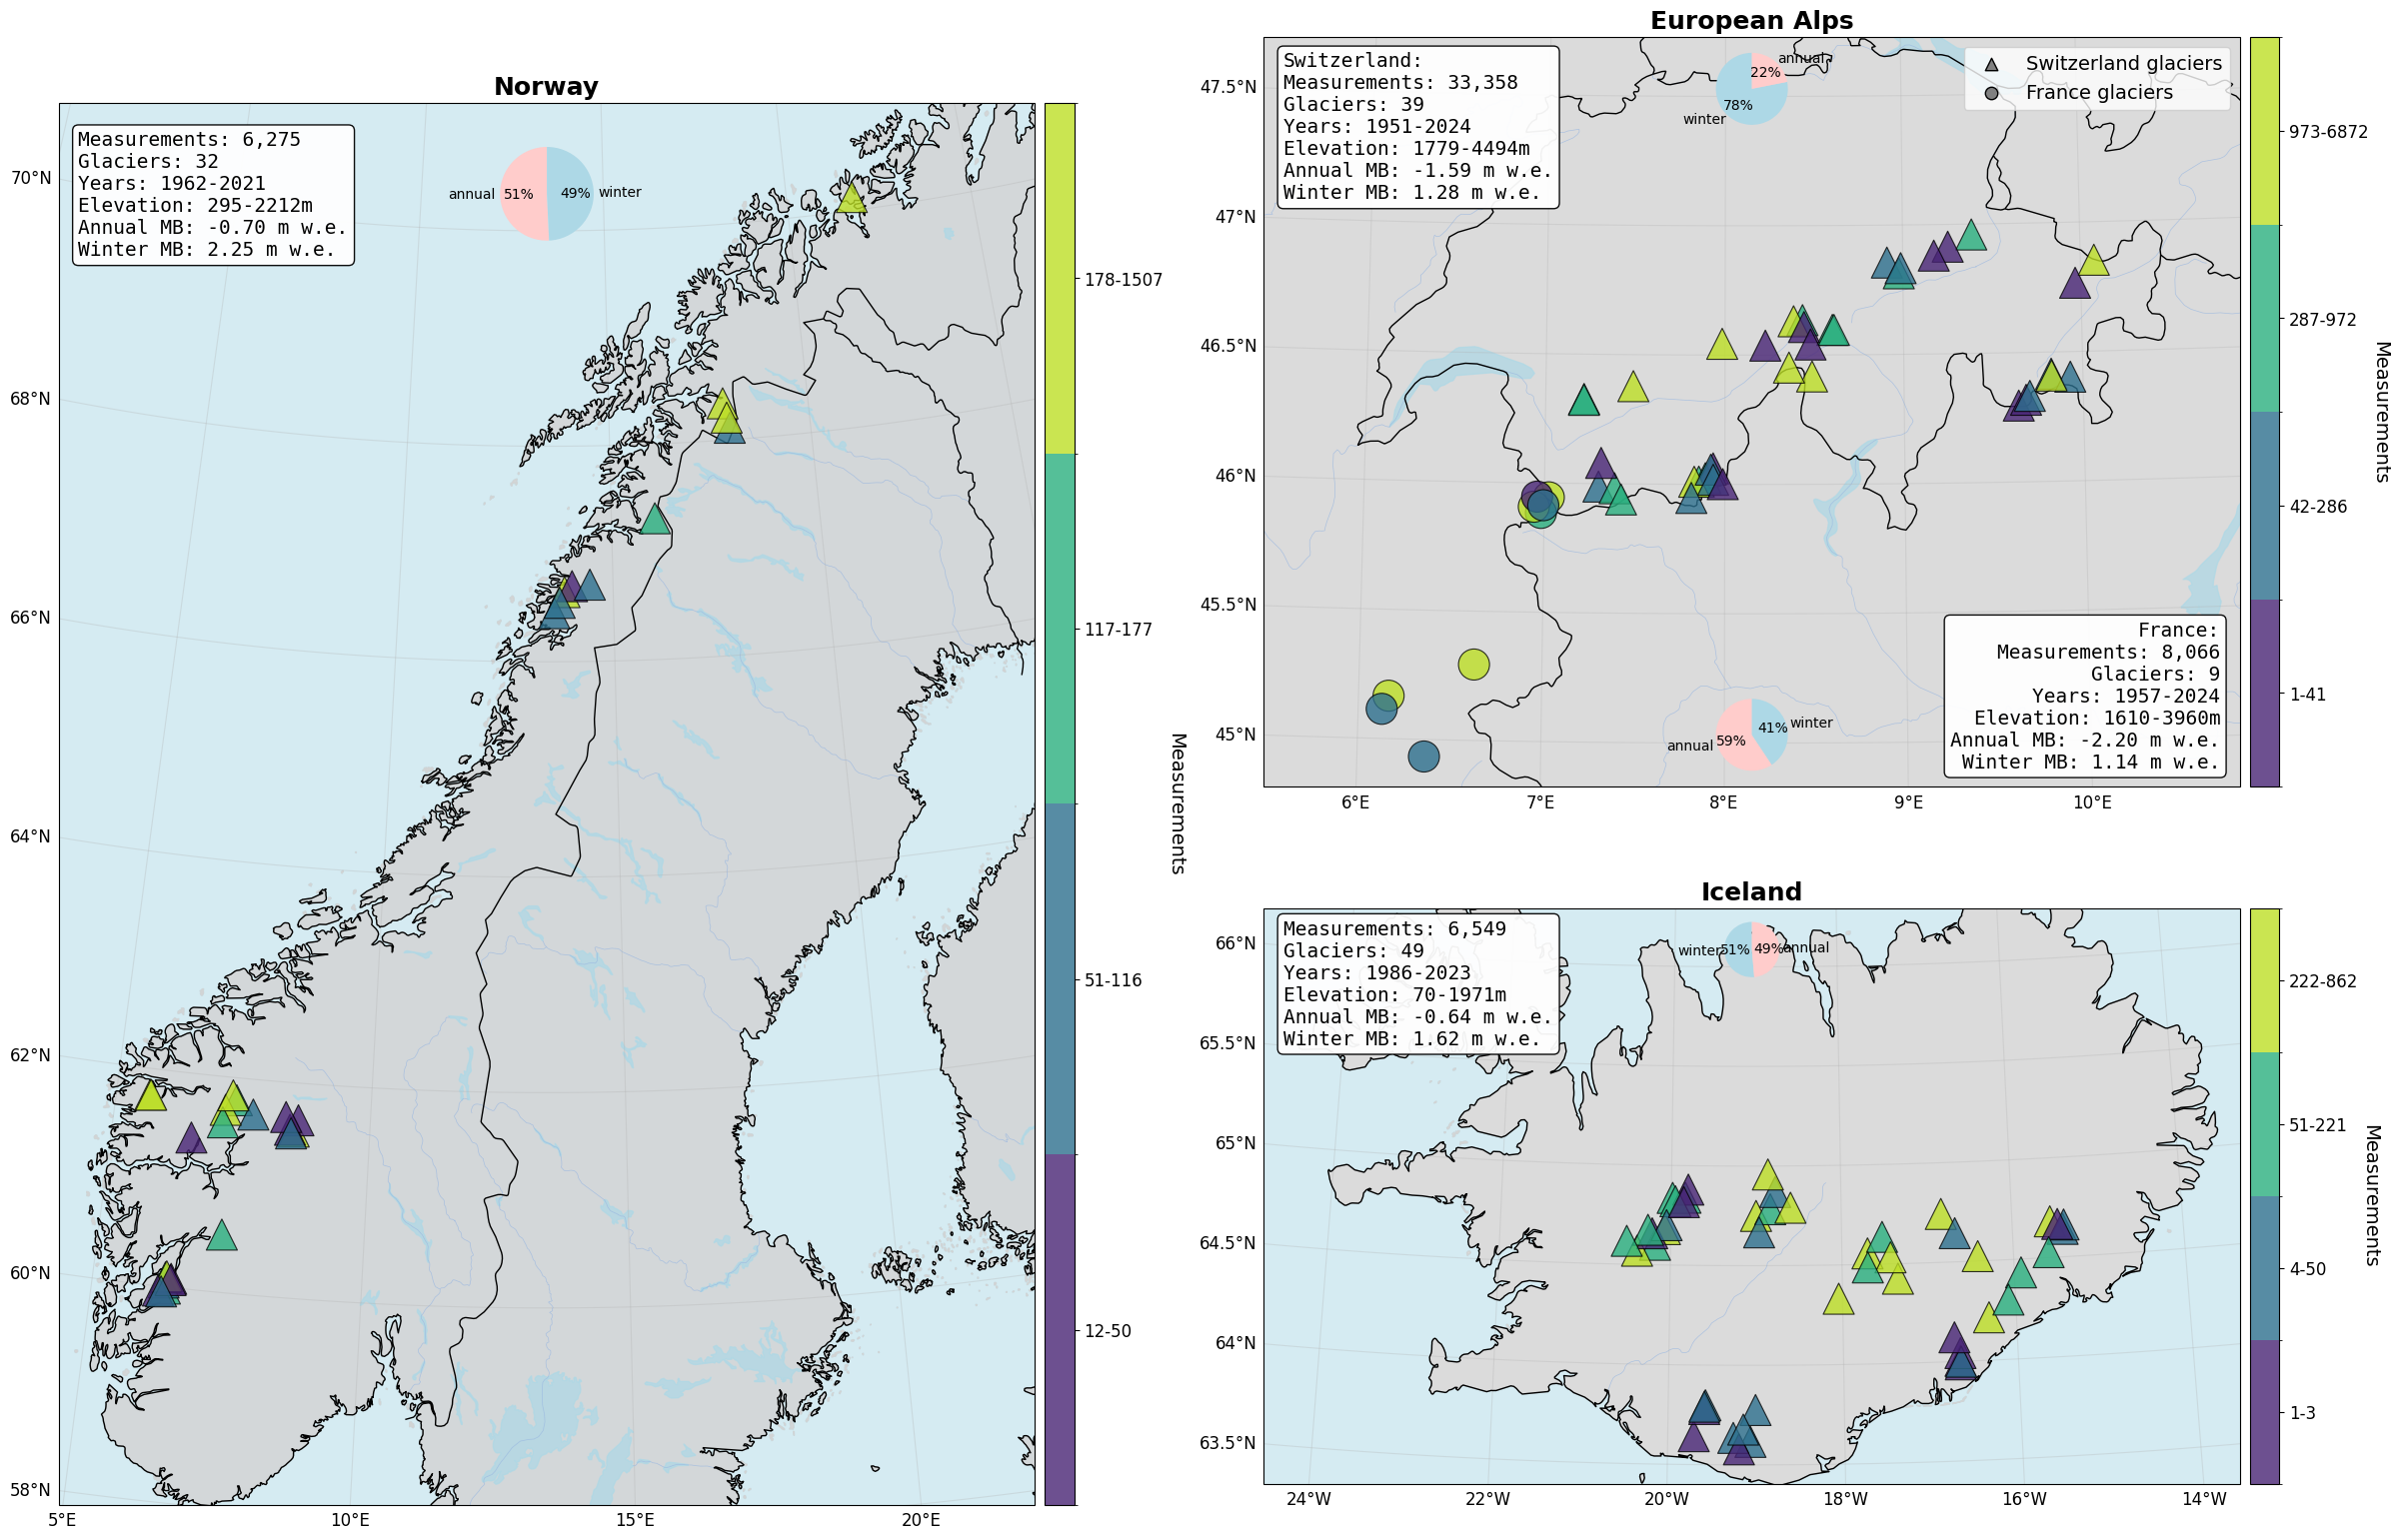

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def create_stats_text(data, region_name):
    """Create formatted statistics text for each region"""
    total_measurements = len(data)
    unique_glaciers = data['GLACIER'].nunique()
    year_range = f"{int(data['YEAR'].min())}-{int(data['YEAR'].max())}"
    elevation_range = f"{int(data['POINT_ELEVATION'].min())}-{int(data['POINT_ELEVATION'].max())}m"
    
    annual_mean = data[data['PERIOD'] == 'annual']['POINT_BALANCE'].mean()
    winter_mean = data[data['PERIOD'] == 'winter']['POINT_BALANCE'].mean()
    
    stats_text = f"Measurements: {total_measurements:,}\nGlaciers: {unique_glaciers}\nYears: {year_range}\nElevation: {elevation_range}\n"
    
    if not np.isnan(annual_mean):
        stats_text += f"Annual MB: {annual_mean:.2f} m w.e.\n"
    if not np.isnan(winter_mean):
        stats_text += f"Winter MB: {winter_mean:.2f} m w.e."
    
    return stats_text

def add_period_pie_chart(ax, data, position='upper right'):
    """Add a small pie chart showing period distribution"""
    period_counts = data['PERIOD'].value_counts()
    
    pie_ax = inset_axes(ax, width="12%", height="12%", loc=position)
    
    # Consistent colors for all pie charts
    colors = []
    for period in period_counts.index:
        if period == 'annual':
            colors.append('#ffcccb')  # Light red
        elif period == 'winter':
            colors.append('#add8e6')  # Light blue
        else:
            colors.append('orange')   # Summer (if exists)
    
    wedges, texts, autotexts = pie_ax.pie(
        period_counts.values, 
        labels=period_counts.index,
        colors=colors,
        autopct='%1.0f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    
    # Remove title - no longer needed
    return pie_ax

def create_better_colormap_and_bounds(measurement_counts):
    """Create much better colormap with even distribution"""
    import matplotlib.colors as mcolors
    
    min_count = measurement_counts.min()
    max_count = measurement_counts.max()
    
    # Use quantiles to create even distribution of glaciers across bins
    if len(measurement_counts) >= 4:
        # Use quartiles for balanced distribution
        bins = [min_count]
        bins.extend(np.percentile(measurement_counts, [25, 50, 75]).astype(int))
        bins.append(max_count + 1)
        
        # Remove duplicates and ensure ascending order
        bins = sorted(list(set(bins)))
        
        # Create labels
        labels = []
        for i in range(len(bins)-1):
            if i == len(bins)-2:  # Last bin
                labels.append(f'{bins[i]}-{max_count}')
            else:
                labels.append(f'{bins[i]}-{bins[i+1]-1}')
    else:
        # Fallback for very small datasets
        bins = [min_count, max_count + 1]
        labels = [f'{min_count}-{max_count}']
    
    # Use viridis colormap for better visibility
    n_colors = len(bins) - 1
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, n_colors))
    
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bins, cmap.N)
    
    return cmap, norm, bins, labels

def get_consistent_projection(bounds):
    """Get Lambert Azimuthal Equal Area projection for all regions"""
    lon_min, lon_max, lat_min, lat_max = bounds
    center_lon = (lon_min + lon_max) / 2
    center_lat = (lat_min + lat_max) / 2
    
    # Use Lambert Azimuthal Equal Area for all regions for consistency
    return ccrs.LambertAzimuthalEqualArea(central_longitude=center_lon, central_latitude=center_lat)

def create_final_regional_maps():
    """Create final layout: Norway on left spanning rows, European Alps top right, Iceland bottom right"""
    
    # Define the maps
    map_configs = [
        {
            'name': 'Norway',
            'datasets': {'Norway': data_NOR},
            'bounds': [4.9, 22, 58.0, 71.0],
            'markers': {'Norway': '^'},  # Triangles
            'position': 'left'  # Left spanning both rows
        },
        {
            'name': 'European Alps',
            'datasets': {'Switzerland': data_CH, 'France': data_FR},
            'bounds': [5.5, 10.8, 44.8, 47.7],
            'markers': {'Switzerland': '^', 'France': 'o'},  # Switzerland triangles, France circles
            'position': (0, 1)  # Top right
        },
        {
            'name': 'Iceland',
            'datasets': {'Iceland': data_ICE},
            'bounds': [-24.5, -13.6, 63.3, 66.2],
            'markers': {'Iceland': '^'},  # Triangles
            'position': (1, 1)  # Bottom right
        }
    ]
    
    # Create figure with custom grid layout
    fig = plt.figure(figsize=(24, 16))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
    
    for config in map_configs:
        # Create subplot based on position
        if config['position'] == 'left':
            # Norway spans both rows on left
            ax = fig.add_subplot(gs[:, 0], projection=get_consistent_projection(config['bounds']))
        else:
            row, col = config['position']
            ax = fig.add_subplot(gs[row, col], projection=get_consistent_projection(config['bounds']))
        
        # Set extent
        ax.set_extent(config['bounds'], crs=ccrs.PlateCarree())
        
        # Add detailed map features - FORCE land to be gray with high zorder
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5, zorder=0)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.8, zorder=1)  # Higher alpha and zorder
        ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=3)
        ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=3)
        ax.add_feature(cfeature.LAKES, color='lightblue', alpha=0.7, zorder=2)
        ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.7, zorder=2)
        
        # Combine data from all regions in this map
        all_glacier_data = []
        
        for region_name, data in config['datasets'].items():
            glacier_locations = data.groupby('GLACIER').agg({
                'POINT_LAT': 'first',
                'POINT_LON': 'first',
                'POINT_ID': 'count'
            }).reset_index()
            glacier_locations.rename(columns={'POINT_ID': 'measurement_count'}, inplace=True)
            glacier_locations['region'] = region_name
            all_glacier_data.append(glacier_locations)
        
        combined_glacier_data = pd.concat(all_glacier_data, ignore_index=True)
        
        # Create better colormap based on measurement counts
        cmap, norm, bounds, labels = create_better_colormap_and_bounds(combined_glacier_data['measurement_count'])
        
        # Plot points for each region with different markers - CONSISTENT SIZE
        for region_name in config['datasets'].keys():
            region_data = combined_glacier_data[combined_glacier_data['region'] == region_name]
            
            scatter = ax.scatter(
                region_data['POINT_LON'], 
                region_data['POINT_LAT'],
                c=region_data['measurement_count'],
                s=500,
                alpha=0.8, 
                edgecolors='black', 
                linewidth=0.8,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                marker=config['markers'][region_name],
                zorder=5,
                label=f'{region_name} glaciers'
            )
        
        # Create colorbar that matches the height of the map
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
        
        cbar = plt.colorbar(scatter, cax=cax, boundaries=bounds, ticks=bounds[:-1])
        cbar.set_label('Measurements', rotation=270, labelpad=15, fontsize=14)  # CONSISTENT font size
        
        # Set custom tick labels
        tick_positions = [(bounds[i] + bounds[i+1])/2 for i in range(len(bounds)-1)]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(labels, fontsize=12)  # CONSISTENT font size
        
        ax.set_title(f'{config["name"]}', fontsize=18, fontweight='bold')  # CONSISTENT font size
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 12}  # CONSISTENT font size
        gl.ylabel_style = {'size': 12}  # CONSISTENT font size
        
        # Handle positioning based on map type
        if config['name'] == 'European Alps':
            # For European Alps: Switzerland top-left + pie next to it, France bottom-right + pie to left
            legend_elements = []
            
            for idx, (region_name, data) in enumerate(config['datasets'].items()):
                # Add to legend
                marker_style = config['markers'][region_name]
                legend_elements.append(plt.scatter([], [], marker=marker_style, s=80, 
                                                 c='gray', edgecolors='black', 
                                                 label=f'{region_name} glaciers'))
            
            # Add legend
            ax.legend(handles=legend_elements, loc='upper right', fontsize=14)  # CONSISTENT font size
            
            # Switzerland stats in upper left + pie chart next to it
            switzerland_stats = create_stats_text(data_CH, 'Switzerland')
            ax.text(0.02, 0.98, f"Switzerland:\n{switzerland_stats}", transform=ax.transAxes, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.95),
                   fontsize=14, fontfamily='monospace', zorder=10)  # CONSISTENT font size
            
            # Switzerland pie chart next to stats (upper center left)
            add_period_pie_chart(ax, data_CH, 'upper center')
            
            # France stats in lower right + pie chart to the left
            france_stats = create_stats_text(data_FR, 'France')
            ax.text(0.98, 0.02, f"France:\n{france_stats}", transform=ax.transAxes, 
                   verticalalignment='bottom', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.95),
                   fontsize=14, fontfamily='monospace', zorder=10)  # CONSISTENT font size
            
            # France pie chart to the left of stats (lower center right)
            add_period_pie_chart(ax, data_FR, 'lower center')
            
        else:
            # For single regions (Norway, Iceland): stats in upper left + pie next to it
            region_name = list(config['datasets'].keys())[0]
            data = list(config['datasets'].values())[0]
            
            # Stats in upper left
            stats_text = create_stats_text(data, region_name)
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.95),
                   fontsize=14, fontfamily='monospace', zorder=10)  # CONSISTENT font size
            
            # Pie chart next to stats (upper center left)
            add_period_pie_chart(ax, data, 'upper center')
    
    plt.tight_layout()
    return fig

# Create the final layout map
final_fig = create_final_regional_maps()
plt.show()

# Save the combined figure
#final_fig.savefig("glacier_maps_combined.pdf", dpi=300, bbox_inches='tight', format='pdf')


In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def create_stats_text(data, region_name):
    """Create formatted statistics text for each region"""
    total_measurements = len(data)
    unique_glaciers = data['GLACIER'].nunique()
    year_range = f"{int(data['YEAR'].min())}-{int(data['YEAR'].max())}"
    elevation_range = f"{int(data['POINT_ELEVATION'].min())}-{int(data['POINT_ELEVATION'].max())}m"
    
    annual_mean = data[data['PERIOD'] == 'annual']['POINT_BALANCE'].mean()
    winter_mean = data[data['PERIOD'] == 'winter']['POINT_BALANCE'].mean()
    
    stats_text = f"Measurements: {total_measurements:,}\nGlaciers: {unique_glaciers}\nPeriod: {year_range}\nElevation: {elevation_range}\n"
    
    if not np.isnan(annual_mean):
        stats_text += f"Annual MB: {annual_mean:.2f} m w.e.\n"
    if not np.isnan(winter_mean):
        stats_text += f"Winter MB: {winter_mean:.2f} m w.e."
    
    return stats_text

def add_period_pie_chart(ax, data, region_name, position='upper right', show_title=True):
    """Add a small pie chart showing period distribution"""
    period_counts = data['PERIOD'].value_counts()
    
    pie_ax = inset_axes(ax, width="15%", height="15%", loc=position)
    
    # Consistent colors for all pie charts
    colors = []
    for period in period_counts.index:
        if period == 'annual':
            colors.append('#ffcccb')  # Light red
        elif period == 'winter':
            colors.append('#add8e6')  # Light blue
        else:
            colors.append('orange')   # Summer (if exists)
    
    wedges, texts, autotexts = pie_ax.pie(
        period_counts.values, 
        labels=period_counts.index,
        colors=colors,
        autopct='%1.0f%%',
        startangle=90,
        textprops={'fontsize': 13}
    )
    
    # Only show title if requested
    if show_title:
        pie_ax.set_title(region_name, fontsize=14, fontweight='bold')

def create_better_colormap_and_bounds(measurement_counts):
    """Create much better colormap with even distribution"""
    import matplotlib.colors as mcolors
    
    min_count = measurement_counts.min()
    max_count = measurement_counts.max()
    
    # Use quantiles to create even distribution of glaciers across bins
    if len(measurement_counts) >= 4:
        # Use quartiles for balanced distribution
        bins = [min_count]
        bins.extend(np.percentile(measurement_counts, [25, 50, 75]).astype(int))
        bins.append(max_count + 1)
        
        # Remove duplicates and ensure ascending order
        bins = sorted(list(set(bins)))
        
        # Create labels
        labels = []
        for i in range(len(bins)-1):
            if i == len(bins)-2:  # Last bin
                labels.append(f'{bins[i]}-{max_count}')
            else:
                labels.append(f'{bins[i]}-{bins[i+1]-1}')
    else:
        # Fallback for very small datasets
        bins = [min_count, max_count + 1]
        labels = [f'{min_count}-{max_count}']
    
    # Use viridis colormap for better visibility
    n_colors = len(bins) - 1
    colors = plt.cm.viridis(np.linspace(0.1, 0.9, n_colors))
    
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bins, cmap.N)
    
    return cmap, norm, bins, labels

def get_consistent_projection(bounds):
    """Get Lambert Azimuthal Equal Area projection for all regions"""
    lon_min, lon_max, lat_min, lat_max = bounds
    center_lon = (lon_min + lon_max) / 2
    center_lat = (lat_min + lat_max) / 2
    
    # Use Lambert Azimuthal Equal Area for all regions for consistency
    return ccrs.LambertAzimuthalEqualArea(central_longitude=center_lon, central_latitude=center_lat)

def create_individual_maps():
    """Create individual maps for each region"""
    
    def create_single_map(config):
        """Helper function to create a single map"""
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(1, 1, 1, projection=get_consistent_projection(config['bounds']))
        
        # Set extent
        ax.set_extent(config['bounds'], crs=ccrs.PlateCarree())
        
        # Add detailed map features - FORCE land to be gray
        ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5, zorder=0)
        ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.8, zorder=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=1, zorder=3)
        ax.add_feature(cfeature.BORDERS, linewidth=1, zorder=3)
        ax.add_feature(cfeature.LAKES, color='lightblue', alpha=0.7, zorder=2)
        ax.add_feature(cfeature.RIVERS, linewidth=0.5, alpha=0.7, zorder=2)
        
        # Combine data from all regions in this map
        all_glacier_data = []
        
        for region_name, data in config['datasets'].items():
            glacier_locations = data.groupby('GLACIER').agg({
                'POINT_LAT': 'first',
                'POINT_LON': 'first',
                'POINT_ID': 'count'
            }).reset_index()
            glacier_locations.rename(columns={'POINT_ID': 'measurement_count'}, inplace=True)
            glacier_locations['region'] = region_name
            all_glacier_data.append(glacier_locations)
        
        combined_glacier_data = pd.concat(all_glacier_data, ignore_index=True)
        
        # Create better colormap based on measurement counts
        cmap, norm, bounds, labels = create_better_colormap_and_bounds(combined_glacier_data['measurement_count'])
        
        # Plot points for each region with different markers
        for region_name in config['datasets'].keys():
            region_data = combined_glacier_data[combined_glacier_data['region'] == region_name]
            
            scatter = ax.scatter(
                region_data['POINT_LON'], 
                region_data['POINT_LAT'],
                c=region_data['measurement_count'],
                s=120,
                alpha=0.8, 
                edgecolors='black', 
                linewidth=0.8,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                marker=config['markers'][region_name],
                zorder=5,
                label=f'{region_name} glaciers'
            )
        
        # Create colorbar
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1, axes_class=plt.Axes)
        
        cbar = plt.colorbar(scatter, cax=cax, boundaries=bounds, ticks=bounds[:-1])
        cbar.set_label('Measurements', rotation=270, labelpad=15, fontsize=16)
        
        # Set custom tick labels
        tick_positions = [(bounds[i] + bounds[i+1])/2 for i in range(len(bounds)-1)]
        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(labels, fontsize=14)
        
        ax.set_title(f'{config["name"]}', fontsize=20, fontweight='bold')
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 16}
        gl.ylabel_style = {'size': 16}
        
        # Add legend and statistics
        if len(config['datasets']) > 1:
            # Multiple regions (Alps)
            legend_elements = []
            stats_text_combined = ""
            
            for idx, (region_name, data) in enumerate(config['datasets'].items()):
                marker_style = config['markers'][region_name]
                legend_elements.append(plt.scatter([], [], marker=marker_style, s=80, 
                                                 c='gray', edgecolors='black', 
                                                 label=f'{region_name} glaciers'))
                
                stats_text_combined += f"{region_name}:\n" + create_stats_text(data, region_name)
                if idx < len(config['datasets']) - 1:
                    stats_text_combined += "\n\n"
            
            ax.legend(handles=legend_elements, loc='upper right', fontsize=16)
            ax.text(0.02, 0.98, stats_text_combined, transform=ax.transAxes, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.95),
                   fontsize=16, fontfamily='monospace', zorder=10)
            
            # Add pie charts for both regions with titles
            pie_positions = ['lower right', 'lower left']
            for idx, (region_name, data) in enumerate(config['datasets'].items()):
                add_period_pie_chart(ax, data, region_name, pie_positions[idx], show_title=True)
        else:
            # Single region
            region_name = list(config['datasets'].keys())[0]
            data = list(config['datasets'].values())[0]
            
            stats_text = create_stats_text(data, region_name)
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.95),
                   fontsize=16, fontfamily='monospace', zorder=10)
            
            add_period_pie_chart(ax, data, region_name, 'lower right', show_title=False)
        
        plt.tight_layout()
        return fig
    
    # Define individual map configurations
    individual_configs = [
        {
            'name': 'Norway',
            'datasets': {'Norway': data_NOR},
            'bounds': [4.9, 22.5, 58.0, 71.0],
            'markers': {'Norway': '^'}
        },
        {
            'name': 'European Alps',
            'datasets': {'Switzerland': data_CH, 'France': data_FR},
            'bounds': [5.5, 10.8, 44.5, 48.0],
            'markers': {'Switzerland': '^', 'France': 'o'}
        },
        {
            'name': 'Iceland',
            'datasets': {'Iceland': data_ICE},
            'bounds': [-25.0, -13.0, 63.3, 66.6],
            'markers': {'Iceland': '^'}
        }
    ]
    
    figures = {}
    
    for config in individual_configs:
        print(f"Creating {config['name']} map...")
        fig = create_single_map(config)
        figures[config['name']] = fig
        plt.show()
        
        # Save the figure for LaTeX
        filename = f"glacier_map_{config['name'].lower().replace(' ', '_')}.pdf"
        fig.savefig(filename, dpi=300, bbox_inches='tight', format='pdf')
        print(f"Saved {filename}")
    
    return figures

individual_figures = create_individual_maps()